# Project: Predicting FDA Approval of Biological Products

**Research Question:**  
How can we predict whether a biological product will be FDA-approved or rejected based on its applicant, product type, dosage, and other features?

---

## Project Overview and ML Pipeline

This project aims to develop predictive models to classify biological products as FDA-approved or rejected. The main data source is the FDA Purple Book, which provides detailed records on licensed biological products including biosimilars and reference products.

The end goal is to provide a reliable predictive tool to assist FDA reviewers in decision-making.

### Machine Learning Pipeline Steps Covered:

1. **Data Acquisition and Exploration:**  
   - Obtained data from the FDA Purple Book database.  
   - Explored data distributions, missing values, and feature types.

2. **Data Preprocessing and Feature Engineering:**  
   - Cleaned and encoded categorical variables.  
   - Handled missing values and duplicates.  
   - Created target variable for approval status.

3. **Model Building:**  
   - Developed multiple classification models: Logistic Regression, KNN, Decision Tree, SVM, Random Forest, and XGBoost.  
   - Implemented hyperparameter tuning to optimize performance.

4. **Model Evaluation:**  
   - Compared models based on training/test accuracy, precision, recall, F1-score, and cross-validation metrics.  
   - Analyzed overfitting and stability.

5. **Ensemble Modeling:**  
   - Created a stacking ensemble combining individual models to improve predictive accuracy and robustness.

6. **Interpretation and Next Steps:**  
   - Summarized key findings and recommended model deployment strategies and further improvements.

---

This structured approach ensures a thorough and reproducible process from raw data to actionable insights.


### Getting Started

Expected Data Source(s): The primary data source will be the FDA Purple Book, which contains information on FDA-licensed biological products, including licensed biosimilar and interchangeable products, and their reference products. The data can be accessed via the official FDA website: FDA Purple Book Database.



In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tabulate import tabulate

# Time utility
import time
import math  # Added to support functions like math.ceil

# For inline plotting in Jupyter notebooks
%matplotlib inline

# Scikit-learn: Model building and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# XGBoost
from xgboost import XGBClassifier


# Data Collection

**Step 1_Data Collection: Load the Dataset**

In [6]:
# Load the Purple Book dataset. Please refer the FDA website-https://purplebooksearch.fda.gov/downloads
df = pd.read_csv('data/purplebook.csv')
print("Data Loaded Successfully")

Data Loaded Successfully


**Step 2_Create Target Column (Approval Status)**

We create a new column Approval_Status based on 'Approval Date' and 'Marketing Status' to define approved vs rejected/not approved products.

In [8]:
# Define a function to determine approval status based on 'Approval Date' and 'Marketing Status'
# A product is considered 'Approved' if it has a non-null approval date and a valid marketing status
def determine_approval_status(row):
    if pd.notnull(row['Approval Date']) and row['Marketing Status'] in ['Licensed', 'Rx']:
        return 'Approved'
    else:
        return 'Rejected or Not Approved'

# Apply the function to create a new column 'Approval_Status' with labels: 'Approved' or 'Rejected or Not Approved'
df['Approval_Status'] = df.apply(determine_approval_status, axis=1)

# Convert the categorical approval status into binary format:
# 1 for 'Approved', 0 for 'Rejected or Not Approved'
df['Approval_Status_binary'] = df['Approval_Status'].map({'Approved': 1, 'Rejected or Not Approved': 0})


# Data Exploration (EDA – Exploratory Data Analysis)

**Step 3_Data Exploration: Preview the First Few Rows of the Dataset**

In [11]:
#Quick overview
df.head()

,N/R/U,Applicant,BLA Number,Proprietary Name,Proper Name,BLA Type,Strength,Dosage Form,Route of Administration,Product Presentation,...,License Number,Product Number,Center,Date of First Licensure,Exclusivity Expiration Date,First Interchangeable Exclusivity Exp. Date,Ref. Product Exclusivity Exp. Date,Orphan Exclusivity Exp. Date,Approval_Status,Approval_Status_binary
0,U,Grifols Therapeutics LLC,103174,"prolastin,prolastin-c,prolastin-c liquid",Alpha-1-Proteinase Inhibitor (Human),351(a),1000MG,For Injection,Intravenous,Single-Dose Vial,...,1871,1,CBER,NaN,NaN,NaN,NaN,2-Dec-94,Approved,1
1,U,Grifols Therapeutics LLC,103174,"prolastin,prolastin-c,prolastin-c liquid",Alpha-1-Proteinase Inhibitor (Human),351(a),500MG,For Injection,Intravenous,Single-Dose Vial,...,1871,2,CBER,NaN,NaN,NaN,NaN,2-Dec-94,Rejected or Not Approved,0
2,U,Grifols Therapeutics LLC,103174,"prolastin,prolastin-c,prolastin-c liquid",Alpha-1-Proteinase Inhibitor (Human),351(a),1000MG/20ML,Injection,Intravenous,Single-Dose Vial,...,1871,3,CBER,NaN,NaN,NaN,NaN,2-Dec-94,Approved,1
3,U,Grifols Therapeutics LLC,103174,"prolastin,prolastin-c,prolastin-c liquid",Alpha-1-Proteinase Inhibitor (Human),351(a),4000MG/80ML,Injection,Intravenous,Single-Dose Vial,...,1871,4,CBER,NaN,NaN,NaN,NaN,2-Dec-94,Approved,1
4,U,Grifols Therapeutics LLC,103174,"prolastin,prolastin-c,prolastin-c liquid",Alpha-1-Proteinase Inhibitor (Human),351(a),500MG/10ML,Injection,Intravenous,Single-Dose Vial,...,1871,5,CBER,NaN,NaN,NaN,NaN,2-Dec-94,Approved,1


**Step 4_Data Exploration: Dataset Info**

In [13]:
#Dataset Info
print("\n Dataset Info:")
print(df.info())


 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6279 entries, 0 to 6278
Data columns (total 27 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   N/R/U                                        194 non-null    object 
 1   Applicant                                    6279 non-null   object 
 2   BLA Number                                   6279 non-null   int64  
 3   Proprietary Name                             5262 non-null   object 
 4   Proper Name                                  6279 non-null   object 
 5   BLA Type                                     6279 non-null   object 
 6   Strength                                     6276 non-null   object 
 7   Dosage Form                                  6255 non-null   object 
 8   Route of Administration                      6255 non-null   object 
 9   Product Presentation                         6174 non-null

**Step 5_Data Exploration: Check for Missing Values in the Dataset**

In [15]:
# Display the count of missing (null) values in each column of the dataframe
print("Missing Values in Each Column:")
print(df.isnull().sum())


Missing Values in Each Column:
N/R/U                                          6085
Applicant                                         0
BLA Number                                        0
Proprietary Name                               1017
Proper Name                                       0
BLA Type                                          0
Strength                                          3
Dosage Form                                      24
Route of Administration                          24
Product Presentation                            105
Marketing Status                                  0
Licensure                                         0
Approval Date                                    45
Ref. Product Proper Name                       2872
Ref. Product Proprietary Name                  5538
Supplement Number                              2255
Submission Type                                  27
License Number                                    0
Product Number                   

**Step 6_Data Exploration: Check for Duplicate Rows in the Dataset**

In [17]:
# Check for duplicate rows in the dataset
# .duplicated() returns a Boolean Series; .sum() counts how many are True (i.e., duplicates)
print("Checking for duplicates:")
print(f"Number of duplicate rows: {df.duplicated().sum()}")


Checking for duplicates:
Number of duplicate rows: 4158


**Step 7_Data Exploration: Visualize Missing Values Using a Heatmap**

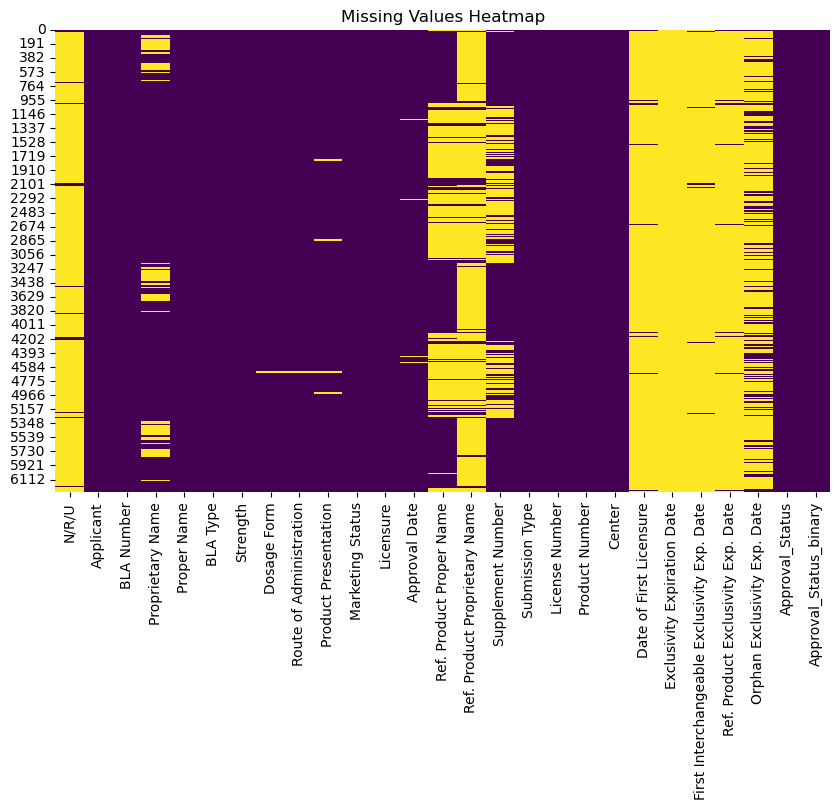

In [19]:
# Visualizing missing values in the dataset using a heatmap
# Each yellow/bright line indicates missing data in a column

plt.figure(figsize=(10, 6))  # Set the figure size
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')  # Create heatmap without color bar
plt.title('Missing Values Heatmap')  # Set plot title
plt.show()  # Display the plot



**Step 8_Data Exploration: Perform Descriptive Analytics on the Dataset**

In [21]:
# Set pandas option to format float values to 2 decimal places for better readability
pd.set_option('display.float_format', '{:.2f}'.format)

# Generate descriptive statistics for all columns (numerical and categorical)
df.describe(include='all')
 

,N/R/U,Applicant,BLA Number,Proprietary Name,Proper Name,BLA Type,Strength,Dosage Form,Route of Administration,Product Presentation,...,License Number,Product Number,Center,Date of First Licensure,Exclusivity Expiration Date,First Interchangeable Exclusivity Exp. Date,Ref. Product Exclusivity Exp. Date,Orphan Exclusivity Exp. Date,Approval_Status,Approval_Status_binary
count,194,6279,6279.00,5262,6279,6279,6276,6255,6255,6174,...,6279.00,6279.00,6279,99,0.00,106,99,1603,6279,6279.00
unique,2,258,NaN,708,611,3,818,24,31,26,...,NaN,NaN,2,30,NaN,9,30,228,2,NaN
top,U,Amgen Inc.,NaN,Aranesp,somatropin,351(a),"10,000BAU/ML",Injection,Subcutaneous,Single-Dose Vial,...,NaN,NaN,CDER,29-Aug-12,NaN,Date TBD,29-Feb-24,24-Mar-02,Approved,NaN
freq,120,329,NaN,147,162,5700,288,2264,2164,2633,...,NaN,NaN,3218,6,NaN,39,6,54,4802,NaN
mean,NaN,NaN,240463.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1511.63,3.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.76
std,NaN,NaN,270984.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,649.80,4.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.42
min,NaN,NaN,17016.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
25%,NaN,NaN,103055.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1216.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00
50%,NaN,NaN,125063.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1752.00,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00
75%,NaN,NaN,125738.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2003.00,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00


# Initial Data Understanding

In this section, we summarize the first insights after loading and analyzing the dataset.

---

## Dataset Overview

- **Shape of the Dataset:**  
  The dataset contains **6,279 rows** and **27 columns**.

- **Variables Classification:**
  - **Numeric Columns:** 0
  - **Integer-Categorical Columns:** 3
  - **String-Categorical Columns:** 8
  - **String-Boolean Columns:** 3
  - **Numeric-Boolean Columns:** 1
  - **Discrete String Columns:** 7
  - **Date Time Columns:** 0
  - **ID Columns:** 0
  - **Low-information Columns Identified:** 5 columns can be removed (`N/R/U`, `Date of First Licensure`, `Exclusivity Expiration Date`, `First Interchangeable Exclusivity Exp. Date`, `Ref. Product Exclusivity Exp. Date`)

- **Duplicates:**
  - **4,158 duplicate rows** found.  
    These should be dropped during preprocessing.  
    
---

## Key Takeaways from Data Quality Analysis

| Feature | Type | Key Observations |
|:--------|:-----|:-----------------|
| **Applicant** | Object | No missing values. High cardinality (258 unique values). Recommend hash encoding or text embedding. |
| **BLA Number** | Integer | No missing values. 711 outliers present. Outliers need capping. |
| **Proprietary Name** | Object | 339 missing values (16%). High cardinality (708 unique values). Mixed data types detected. |
| **Proper Name** | Object | No missing values. High cardinality (611 unique values). |
| **BLA Type** | Object | No issues detected. |
| **Strength** | Object | 1 missing value. High cardinality (818 unique values). Mixed types detected. |
| **Dosage Form** | Object | 8 missing values. Rare categories present. Mixed types detected. |
| **Route of Administration** | Object | 8 missing values. Rare categories present. Mixed types detected. |
| **Product Presentation** | Object | 35 missing values. Rare categories present. Mixed types detected. |
| **Marketing Status** | Object | No missing values. Rare categories (`OTC`, `Disc*`) need grouping. |
| **Licensure** | Object | No missing values. Rare category (`Revoked`) needs grouping. |
| **Approval Date** | Object | 15 missing values. High cardinality (908 unique values). Mixed types detected. |
| **Ref. Product Proper Name** | Object | 968 missing values (~46%). Rare categories detected. |
| **Ref. Product Proprietary Name** | Object | 1,861 missing values (~88%). Rare categories detected. |
| **Supplement Number** | Object | 761 missing values (~36%). High cardinality (182 unique values). Mixed types detected. |
| **Submission Type** | Object | 10 missing values. Mixed types detected. |
| **License Number** | Integer | No missing values. 101 outliers detected. |
| **Product Number** | Integer | No missing values. 101 outliers detected. |
| **Center** | Object | No issues detected. |
| **Orphan Exclusivity Exp. Date** | Object | 1,583 missing values (~75%). High cardinality (228 unique values). Mixed types detected. |

---

## Major Data Quality Issues Identified

- **High Missingness:**  
  Columns like `Ref. Product Proprietary Name` (~88%), `Orphan Exclusivity Exp. Date` (~75%), and `Supplement Number` (~36%) have significant missing data.

- **High Cardinality:**  
  Features such as `Applicant`, `Proprietary Name`, `Proper Name`, and `Strength` have hundreds of unique values, which could cause dimensionality issues.

- **Outliers:**  
  - `BLA Number`: 711 outliers detected.
  - `Product Number`: 101 outliers detected.
  - `License Number`: 101 outliers detected.

- **Rare Categories:**  
  Features such as `Marketing Status`, `Licensure`, `Dosage Form`, `Route of Administration`, and `Product Presentation` have rare categories needing grouping.

- **Mixed Data Types:**  
  Several features show mixed data types (`object` and `float`), requiring cleanup.

- **Duplicates:**  
  4,158 duplicate rows found; should be dropped.

- **Low Information Columns:**  
  5 columns identified with very low variance and removed.

---

## Next Steps

1. **Drop duplicate rows** carefully, ensuring data types remain consistent.
2. **Handle missing values:**
   - Impute missing categorical variables with mode or a constant.
   - Consider dropping columns with extreme missingness.
3. **Manage high cardinality:**
   - Use encoding techniques (e.g., hash encoding, embeddings).
4. **Cap or remove outliers** in `BLA Number`, `License Number`, and `Product Number`.
5. **Group rare categories** into "Other" to reduce noise.
6. **Clean mixed data types** in columns showing multiple types.
7. **Feature engineering:**  
   Consider creating new features based on Approval Date (e.g., year, month) if needed.

---


# Data Preprocessing & Cleaning

**Step 1_Data Preprocessing & Cleaning: Drop Unnecessary Columns**

We drop columns that provide minimal value for prediction or serve as unique identifiers

In [25]:
columns_to_drop = [
    'N/R/U', 
    'Date of First Licensure', 
    'Exclusivity Expiration Date', 
    'First Interchangeable Exclusivity Exp. Date', 
    'Ref. Product Exclusivity Exp. Date', 
    'Approval Date'
]

# Drop columns from the dataframe only if they exist
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])



**Step 2_Data Preprocessing & Cleaning: Clean 'Strength' Column, Fill Missing Values, and Drop Duplicates**


In [27]:
# Clean 'Strength' column:
# 1. Convert to string type
df['Strength'] = df['Strength'].astype(str)

# 2. Extract numeric part (digits) from the string
df['Strength'] = df['Strength'].str.extract(r'(\d+)', expand=False)

# 3. Convert extracted values to numeric, coercing errors to NaN
df['Strength'] = pd.to_numeric(df['Strength'], errors='coerce')

# 4. Fill missing values in 'Strength' with the median value
df['Strength'] = df['Strength'].fillna(df['Strength'].median())

# Fill missing values in categorical columns:
# For 'Proprietary Name', fill with the most frequent value (mode)
df['Proprietary Name'] = df['Proprietary Name'].fillna(df['Proprietary Name'].mode()[0])

# For 'Product Presentation', fill missing values with a placeholder string
df['Product Presentation'] = df['Product Presentation'].fillna('Not Available')

# Drop duplicate rows from the dataframe to ensure data quality
df = df.drop_duplicates()


**Step 3_Data Preprocessing & Cleaning: Cap Outliers Using IQR Method**



In [29]:
# Define a function to cap outliers using the IQR method
def cap_outliers_iqr(column):
    Q1 = column.quantile(0.25)  # First quartile (25th percentile)
    Q3 = column.quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1               # Interquartile range
    lower_bound = Q1 - 1.5 * IQR  # Lower bound for outliers
    upper_bound = Q3 + 1.5 * IQR  # Upper bound for outliers
    return column.clip(lower=lower_bound, upper=upper_bound)  # Cap values outside bounds

# Apply the outlier capping function to relevant numeric columns
df['BLA Number'] = cap_outliers_iqr(df['BLA Number'])
df['Strength'] = cap_outliers_iqr(df['Strength'])
df['License Number'] = cap_outliers_iqr(df['License Number'])
df['Product Number'] = cap_outliers_iqr(df['Product Number'])


**Step 4_Data Preprocessing & Cleaning: Group Rare Categories in Categorical Columns**

This step reduces noise and prevents sparsity in encoding by consolidating infrequent categories.

In [31]:
# Define a function to group rare categories (below a frequency threshold) into 'Other'
def group_rare_categories(column, threshold=10):
    value_counts = column.value_counts()  # Count occurrences of each category
    rare_values = value_counts[value_counts < threshold].index  # Identify rare categories
    return column.replace(rare_values, 'Other')  # Replace rare values with 'Other'

# List of categorical columns where rare category grouping is to be applied
categorical_columns_for_rare = [
    'Proprietary Name', 
    'Proper Name', 
    'Ref. Product Proper Name', 
    'Licensure', 
    'Product Presentation', 
    'Ref. Product Proprietary Name'
]

# Apply the function to each column in the list
for col in categorical_columns_for_rare:
    df[col] = group_rare_categories(df[col])


 **Step 5_Data Preprocessing & Cleaning: Convert Data Types and Fill Missing Categorical Values**

In [33]:
# Convert specific columns to string type to ensure consistency before filling missing values
df['Route of Administration'] = df['Route of Administration'].astype(str)
df['Ref. Product Proper Name'] = df['Ref. Product Proper Name'].astype(str)

# Fill missing values in categorical columns using the most frequent value (mode)
df['Dosage Form'] = df['Dosage Form'].fillna(df['Dosage Form'].mode()[0])
df['Route of Administration'] = df['Route of Administration'].fillna(df['Route of Administration'].mode()[0])
df['Ref. Product Proper Name'] = df['Ref. Product Proper Name'].fillna(df['Ref. Product Proper Name'].mode()[0])
df['Supplement Number'] = df['Supplement Number'].fillna(df['Supplement Number'].mode()[0])
df['Submission Type'] = df['Submission Type'].fillna(df['Submission Type'].mode()[0])
df['Orphan Exclusivity Exp. Date'] = df['Orphan Exclusivity Exp. Date'].fillna(df['Orphan Exclusivity Exp. Date'].mode()[0])


**Step 6_Data Preprocessing & Cleaning: Drop Redundant or Unnecessary Column**

In [35]:
# Drop the 'Ref. Product Proprietary Name' column if it is no longer needed
df = df.drop(columns=['Ref. Product Proprietary Name'])


**Step 7_Data Preprocessing & Cleaning: Group Rare Categories and Standardize Values**

In [37]:
# Group rare categories in 'Applicant' and 'Orphan Exclusivity Exp. Date' using a threshold of 5
df['Applicant'] = group_rare_categories(df['Applicant'], threshold=5)
df['Orphan Exclusivity Exp. Date'] = group_rare_categories(df['Orphan Exclusivity Exp. Date'], threshold=5)

# Standardize 'Marketing Status' values by replacing 'OTC' and 'Disc*' with 'Other'
df['Marketing Status'] = df['Marketing Status'].replace({'OTC': 'Other', 'Disc*': 'Other'})


**Step 8_Data Preprocessing & Cleaning: Apply Log Transformation to 'License Number'**


In [39]:
# Apply log transformation to reduce skewness in 'License Number'
# np.log1p(x) computes log(1 + x), which handles 0 values safely
df['License Number'] = np.log1p(df['License Number'])


**Step 9_Data Preprocessing & Cleaning: Finalize Data Types and Save Cleaned Dataset**

In [41]:
# Convert columns to best possible dtypes (e.g., string, integer, float, boolean)
df = df.convert_dtypes()

# Save the cleaned dataset to a CSV file for downstream tasks like modeling or visualization
df.to_csv('data/purplebook_cleaned_final.csv', index=False)

# Confirmation and preview of the cleaned dataset
print("Data Cleaned Successfully")
print(df.head())



Data Cleaned Successfully
                  Applicant  BLA Number Proprietary Name  \
0  Grifols Therapeutics LLC   103174.00            Other   
1  Grifols Therapeutics LLC   103174.00            Other   
2  Grifols Therapeutics LLC   103174.00            Other   
3  Grifols Therapeutics LLC   103174.00            Other   
4  Grifols Therapeutics LLC   103174.00            Other   

                            Proper Name BLA Type  Strength    Dosage Form  \
0  Alpha-1-Proteinase Inhibitor (Human)   351(a)       485  For Injection   
1  Alpha-1-Proteinase Inhibitor (Human)   351(a)       485  For Injection   
2  Alpha-1-Proteinase Inhibitor (Human)   351(a)       485      Injection   
3  Alpha-1-Proteinase Inhibitor (Human)   351(a)       485      Injection   
4  Alpha-1-Proteinase Inhibitor (Human)   351(a)       485      Injection   

  Route of Administration Product Presentation Marketing Status Licensure  \
0             Intravenous     Single-Dose Vial               Rx  Licensed

# Feature Engineering 

**Step 10_Feature Engineering: Create New Features from Existing Text Columns**

Adding new features based on domain understanding.

In [44]:
# Create numerical features based on the length of text in name columns
df['Proprietary_Name_Length'] = df['Proprietary Name'].apply(lambda x: len(str(x)))
df['Proper_Name_Length'] = df['Proper Name'].apply(lambda x: len(str(x)))

# Create a binary flag for whether the applicant is among the top 10 most frequent
top_applicants = df['Applicant'].value_counts().nlargest(10).index
df['Top_Applicant_Flag'] = df['Applicant'].apply(lambda x: 1 if x in top_applicants else 0)

# Define a function to simplify the 'Route of Administration' into a few key categories
def simplify_route(route):
    route = route.lower()
    if 'injection' in route:
        return 'Injection'
    elif 'oral' in route:
        return 'Oral'
    elif 'topical' in route:
        return 'Topical'
    else:
        return 'Other'

# Apply the route simplification function
df['Route_Simple'] = df['Route of Administration'].apply(simplify_route)


# Data Cleaning - Final check 

The code generates several visualizations to explore the dataset: histograms with KDE for continuous features, count plots for categorical features, a heatmap to visualize missing values, and a correlation heatmap for numerical variables. These plots help to understand the data distribution, detect missing values, and examine relationships between continuous variables, providing valuable insights for further analysis or modeling.

**Step 1_Exploratory Data Analysis (EDA) After data cleaning : Visualize Pairwise Relationships Between Selected Features**

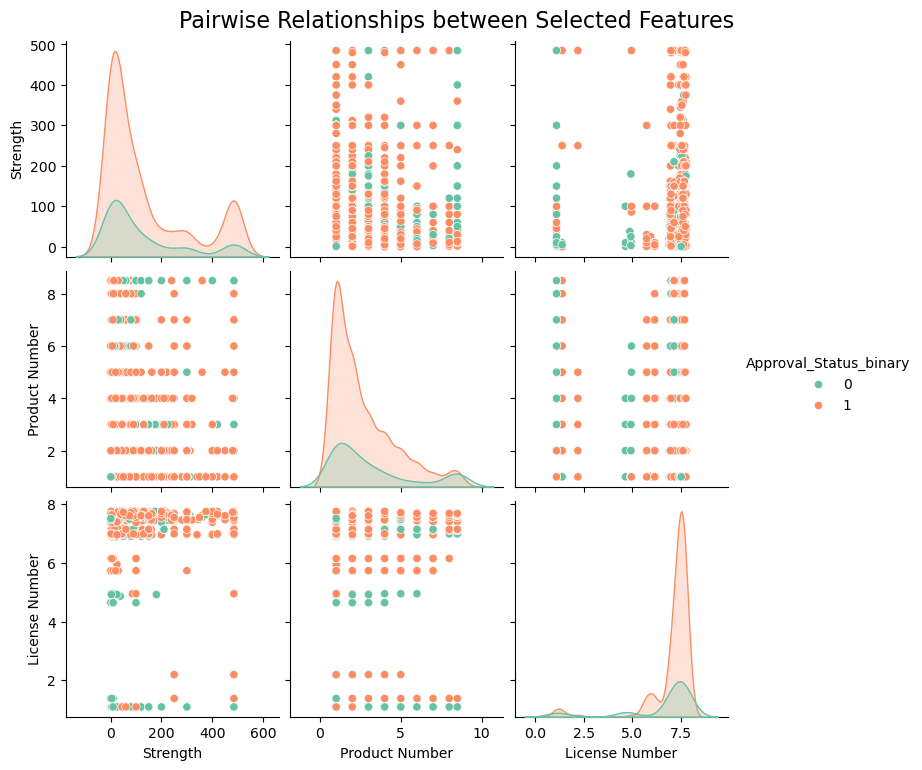

In [47]:
# Select important numerical features along with the target variable for visualization
selected_features = ['Strength', 'Approval_Status_binary', 'Product Number', 'License Number']   

# Create a pairplot to visualize pairwise relationships and class separation
sns.pairplot(df[selected_features], 
             hue='Approval_Status_binary', 
             diag_kind='kde', 
             palette='Set2')

# Add a super title for better context
plt.suptitle('Pairwise Relationships between Selected Features', 
             y=1.02, fontsize=16)

# Display the plot
plt.show()


**Step 2_Exploratory Data Analysis (EDA) After Data Cleaning:Visualization for Continuous Features**

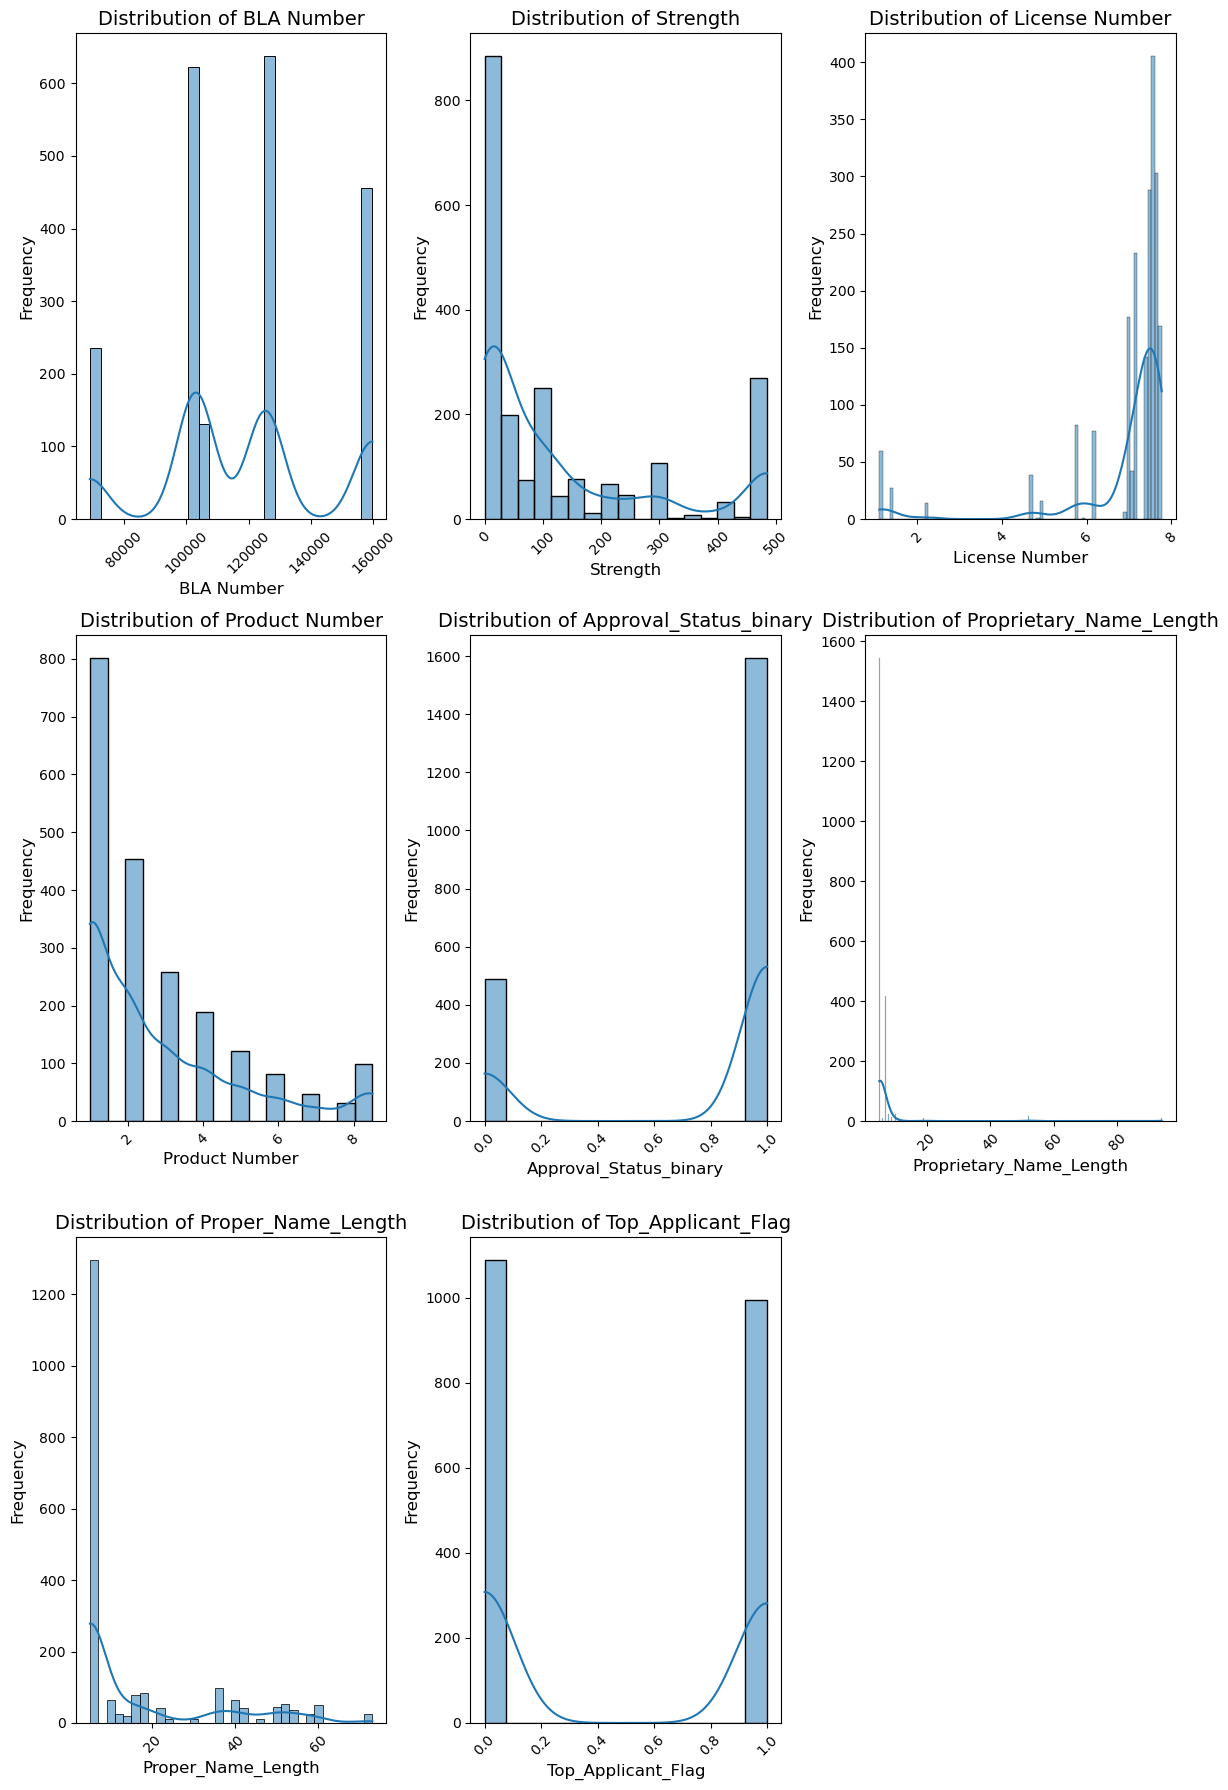

In [49]:
# Select numerical columns for continuous variables
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Set up the plot grid
n_cols = 3  # Number of columns in the subplot grid
n_rows = (len(numerical_columns) // n_cols) + (1 if len(numerical_columns) % n_cols != 0 else 0)

plt.figure(figsize=(12, 6 * n_rows))  # Dynamic figure size based on number of rows
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


**Step 3_Exploratory Data Analysis (EDA) After Data Cleaning: Visualization for Categorical Features**

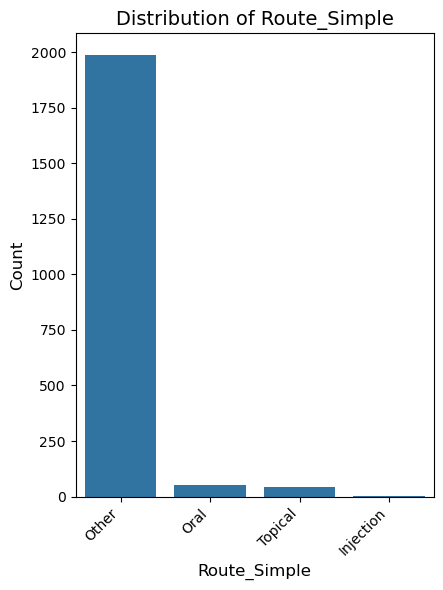

In [51]:
# Select object-type columns (categorical)
categorical_columns = df.select_dtypes(include=['object']).columns

# Set up subplot grid
n_cols = 3
n_rows = (len(categorical_columns) // n_cols) + (1 if len(categorical_columns) % n_cols != 0 else 0)

plt.figure(figsize=(12, 6 * n_rows))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(x=df[col], order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


**Step 4_Exploratory Data Analysis (EDA) After Data Cleaning: Missing Values Heatmap**

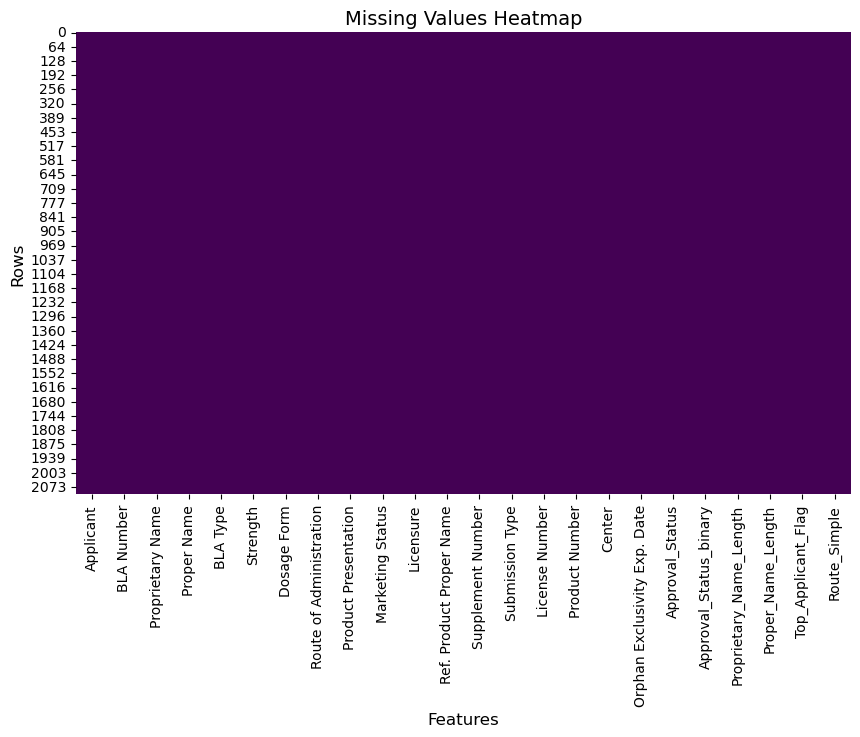

In [53]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Rows', fontsize=12)
plt.show()


**Step 5_Exploratory Data Analysis (EDA) After Data Cleaning: Correlation Heatmap for Numerical Variables**

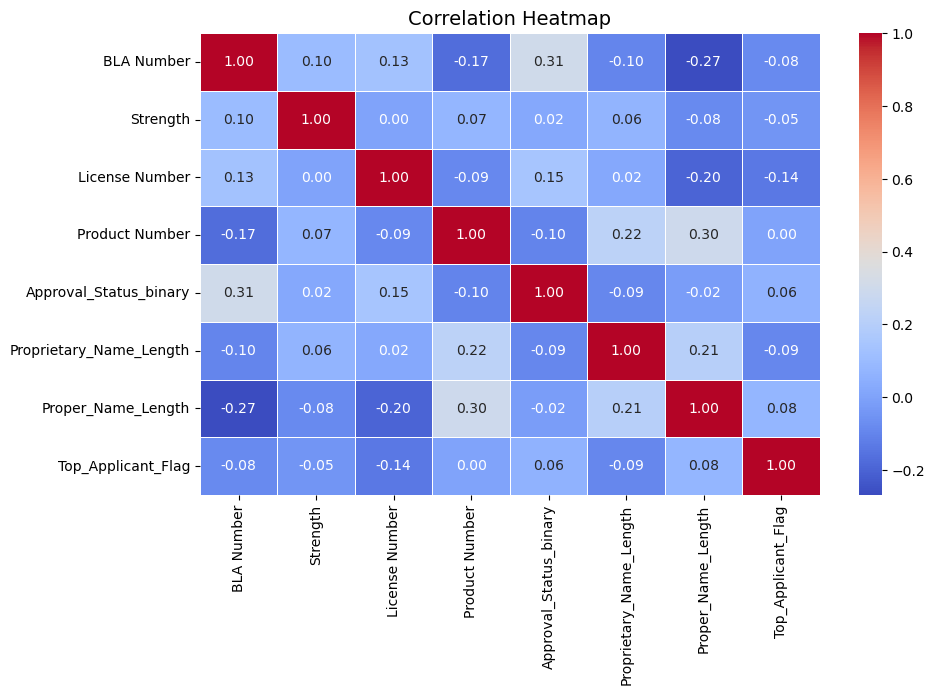

In [55]:
# Compute correlation matrix
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numerical_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=14)
plt.show()


# Baseline Model Development

**Step 1_Base Model Development:Prepare Features and Split Dataset**

In [58]:
# Define features (X) by dropping the target column
X = df.drop(columns=['Approval_Status_binary'])

# Define target variable (y)
y = df['Approval_Status_binary']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

**Step 2_Base Model Development: Build and Evaluate Baseline Model**

For the baseline, you'll predict the most frequent class (i.e., the class with the highest occurrence) for all samples. This can be done easily using a majority class classifier.

In [62]:
# Instantiate DummyClassifier with 'most_frequent' strategy to predict the majority class
baseline_model = DummyClassifier(strategy="most_frequent")

# Train the baseline model on the training data
baseline_model.fit(X_train, y_train)

# Predict target on the test set
y_pred_baseline = baseline_model.predict(X_test)

# Calculate and print accuracy of the baseline model
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")


Baseline Accuracy: 0.7722


# Model Selection, Training, Comparison, Evaluation and Tuning

**Step_1 Model Selection_Let verify if the training data is bias and whether we need to use any balancing technique**


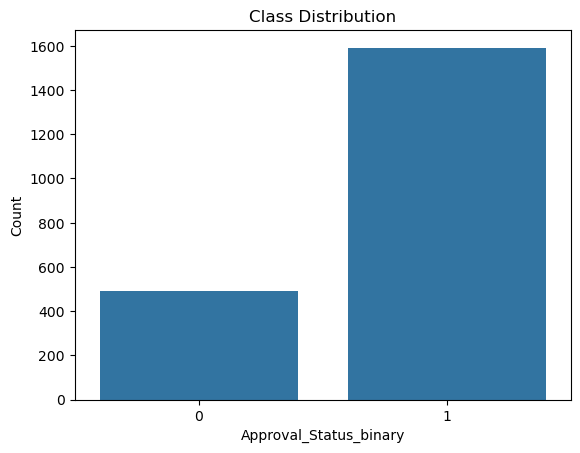

In [65]:
# Visualize the distribution of target classes to detect class imbalance
sns.countplot(x=y)
plt.title("Class Distribution")
plt.xlabel("Approval_Status_binary")
plt.ylabel("Count")
plt.show()


**Step 2_Model Selection: It appears that the training data is biased and needs to be balanced. We will use SMOTE to balance it.**


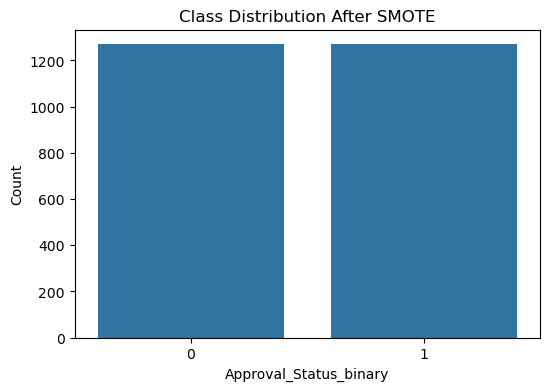

In [67]:
# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['number']).columns

# Define preprocessing pipeline for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
    ]
)

# Fit the preprocessor on training data and transform
X_train_processed = preprocessor.fit_transform(X_train)

# Apply SMOTE to balance the classes in training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)

# Visualize class distribution after SMOTE balancing
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Approval_Status_binary")
plt.ylabel("Count")
plt.show()


**Step 3_Model Training: Build Pipeline with Preprocessing, SMOTE, and Logistic Regression**

Use Logistic Regression to build a basic model on your data using SMOTE. This is to make sure that the model is Realistic, balanced learning; more honest about class 0 vs 1. Best for fairness. 

In [69]:
# Create a pipeline combining preprocessing, SMOTE balancing, and Logistic Regression model
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7146
Confusion Matrix:
[[ 70  25]
 [ 94 228]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.43      0.74      0.54        95
         1.0       0.90      0.71      0.79       322

    accuracy                           0.71       417
   macro avg       0.66      0.72      0.67       417
weighted avg       0.79      0.71      0.74       417



**Step 4_Model Comparison: Evaluate Multiple Classification Models Using Pipeline with SMOTE and Preprocessing**

In [71]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Initialize list to collect results
results = []

# Loop through each model, fit pipeline, and record performance and training time
for name, model in models.items():
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time = round(time.time() - start_time, 2)
    
    train_accuracy = round(pipeline.score(X_train, y_train), 2)
    test_accuracy = round(pipeline.score(X_test, y_test), 2)
    
    results.append([name, train_time, train_accuracy, test_accuracy])

# Create a DataFrame with the results and print it
results_df = pd.DataFrame(results, columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])
print(results_df)


                 Model  Train Time  Train Accuracy  Test Accuracy
0  Logistic Regression        0.04            0.73           0.71
1                  KNN        0.02            0.84           0.78
2        Decision Tree        0.03            0.99           0.83
3                  SVM        0.21            0.76           0.73
4        Random Forest        0.36            0.99           0.85
5              XGBoost        0.21            0.98           0.83


**Step 5_Model Tuning: Hyperparameter Optimization for Logistic Regression Using Pipeline with SMOTE and GridSearchCV**

This tunes Logistic Regression with SMOTE in the pipeline, leveraging GridSearchCV for cross-validated hyperparameter optimization. 

In [73]:
def create_model_pipeline_with_smote(model):
    categorical_columns = X.select_dtypes(include=['object']).columns
    numerical_columns = X.select_dtypes(include=['number']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
        ]
    )

    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    return pipeline

# Define hyperparameter grid for Logistic Regression
param_grid_logistic = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['liblinear', 'saga', 'lbfgs'],
    'classifier__max_iter': [1000, 2000, 5000]
}

# Initialize GridSearchCV with the pipeline and hyperparameters
grid_search_logistic = GridSearchCV(
    create_model_pipeline_with_smote(LogisticRegression(random_state=42)),
    param_grid=param_grid_logistic,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=2
)

# Fit GridSearchCV on training data
grid_search_logistic.fit(X_train, y_train)

# Extract best model and predict on test data
best_logistic_model = grid_search_logistic.best_estimator_
y_pred_logistic = best_logistic_model.predict(X_test)

# Display best hyperparameters and best CV accuracy
print("Best Parameters for Logistic Regression:", grid_search_logistic.best_params_)
print("Cross-Validated Accuracy of Tuned Logistic Regression:", grid_search_logistic.best_score_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for Logistic Regression: {'classifier__C': 1, 'classifier__max_iter': 1000, 'classifier__solver': 'saga'}
Cross-Validated Accuracy of Tuned Logistic Regression: 0.7291291291291291


**Step 6_Model Tuning: Hyperparameter Optimization for K-Nearest Neighbors (KNN) Using Pipeline with SMOTE and GridSearchCV**

This code block tunes KNN hyperparameters (neighbors, weights, distance metric) within a SMOTE-enabled pipeline and evaluates the best model on the test set. 

In [75]:
# Define hyperparameter grid for KNN classifier
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],            # Number of neighbors to consider
    'classifier__weights': ['uniform', 'distance'],         # Weight function used in prediction
    'classifier__metric': ['euclidean', 'manhattan']        # Distance metric to use
}

# Initialize GridSearchCV with the KNN pipeline and hyperparameters
grid_search_knn = GridSearchCV(
    create_model_pipeline_with_smote(KNeighborsClassifier()),  # Pipeline with preprocessing + SMOTE + KNN
    param_grid_knn,
    cv=5,                  # 5-fold cross-validation
    n_jobs=-1              # Use all available CPU cores
)

# Fit GridSearchCV on training data to find the best hyperparameters
grid_search_knn.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print("Best Parameters for KNN:", grid_search_knn.best_params_)

# Get the best model from GridSearchCV and predict on the test set
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)

# Evaluate and print accuracy of the tuned KNN model on test data
print("Accuracy of Tuned KNN:", accuracy_score(y_test, y_pred_knn))


Best Parameters for KNN: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}
Accuracy of Tuned KNN: 0.8009592326139089


**Step 7_Model Tuning: Hyperparameter Optimization for Decision Tree Using Pipeline with SMOTE and GridSearchCV**

This step performs a grid search for tuning decision tree hyperparameters while applying SMOTE inside the pipeline. The best model is evaluated on the test set for accuracy.

In [77]:
# Decision Tree Hyperparameter Tuning
param_grid_tree = {
    'classifier__max_depth': [5, 10, 20, None],          # Max depth of the tree to control overfitting
    'classifier__min_samples_split': [2, 5, 10],         # Minimum samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4]            # Minimum samples required at a leaf node
}

# Initialize GridSearchCV with Decision Tree pipeline including SMOTE and preprocessing
grid_search_tree = GridSearchCV(
    create_model_pipeline_with_smote(DecisionTreeClassifier(random_state=42)),
    param_grid_tree,
    cv=5,
    n_jobs=-1
)

# Fit the grid search on training data
grid_search_tree.fit(X_train, y_train)

# Print best hyperparameters found
print("Best Parameters for Decision Tree:", grid_search_tree.best_params_)

# Retrieve best model and make predictions on test set
best_tree_model = grid_search_tree.best_estimator_
y_pred_tree = best_tree_model.predict(X_test)

# Print accuracy score on test data
print("Accuracy of Tuned Decision Tree:", accuracy_score(y_test, y_pred_tree))


Best Parameters for Decision Tree: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Accuracy of Tuned Decision Tree: 0.8249400479616307


**Step 8_Model Tuning: Hyperparameter Optimization for SVM Using Pipeline with SMOTE and GridSearchCV**

This code performs hyperparameter tuning for an SVM model, using SMOTE inside the pipeline to balance classes during training. The best parameters are printed, and the tuned model is evaluated on the test set.

In [79]:
# Create a pipeline with preprocessing, SMOTE, and SVM classifier
pipeline_svm = create_model_pipeline_with_smote(SVC(random_state=42))

# Define the parameter grid to search over
param_grid = {
    'classifier__kernel': ['linear', 'rbf'],  # SVM kernel types to evaluate
    'classifier__C': [0.1, 1, 10],            # Regularization parameter controlling trade-off
    'classifier__gamma': ['scale', 'auto'],   # Kernel coefficient for 'rbf' kernel
}

# Perform grid search with 5-fold cross-validation and parallel processing
grid_search_svm = GridSearchCV(pipeline_svm, param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search_svm.fit(X_train, y_train)

# Output the best hyperparameters found by GridSearchCV
print("Best parameters found: ", grid_search_svm.best_params_)

# Retrieve the best model pipeline after tuning
best_svm_model = grid_search_svm.best_estimator_

# Predict on the test set using the best SVM model
y_pred_svm = best_svm_model.predict(X_test)

# Print the accuracy of the tuned SVM model on test data
print("Accuracy of Tuned SVM:", accuracy_score(y_test, y_pred_svm))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Accuracy of Tuned SVM: 0.762589928057554


**Step 9_Model Tuning: Hyperparameter Optimization for Random Forest Using Pipeline with SMOTE and GridSearchCV**


In [81]:
# Define hyperparameter grid for Random Forest classifier
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],            # Number of trees in the forest
    'classifier__max_depth': [10, 20, None],               # Maximum depth of each tree
    'classifier__min_samples_split': [2, 5, 10]            # Minimum samples required to split a node
}

# Initialize GridSearchCV with the Random Forest pipeline and hyperparameters
grid_search_rf = GridSearchCV(
    create_model_pipeline_with_smote(RandomForestClassifier(random_state=42)),  # Pipeline with preprocessing + SMOTE + RF
    param_grid_rf,
    cv=5,                  # 5-fold cross-validation
    n_jobs=-1,             # Use all available CPU cores
    scoring='accuracy',    # Optimize for accuracy
    verbose=2              # Show detailed output during training
)

# Fit GridSearchCV on training data to find the best hyperparameters
grid_search_rf.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

# Get the best model from GridSearchCV and predict on the test set
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate and print accuracy of the tuned Random Forest model on test data
print("Accuracy of Tuned Random Forest:", accuracy_score(y_test, y_pred_rf))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for Random Forest: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
Accuracy of Tuned Random Forest: 0.8441247002398081


**Step 10_Model Tuning: Hyperparameter Optimization for XGBoost Using Pipeline with SMOTE and GridSearchCV**


In [83]:
# Define hyperparameter grid for XGBoost classifier
param_grid_xgb = {
    'classifier__n_estimators': [100, 200],                # Number of boosting rounds
    'classifier__max_depth': [3, 6, 10],                   # Maximum tree depth for base learners
    'classifier__learning_rate': [0.01, 0.1, 0.2],         # Step size shrinkage to prevent overfitting
    'classifier__subsample': [0.8, 1.0]                     # Subsample ratio of training instances
}

# Initialize GridSearchCV with the XGBoost pipeline and hyperparameters
grid_search_xgb = GridSearchCV(
    create_model_pipeline_with_smote(
        XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')  # Pipeline with preprocessing + SMOTE + XGBoost
    ),
    param_grid_xgb,
    cv=5,                  # 5-fold cross-validation
    n_jobs=-1,             # Use all CPU cores
    scoring='accuracy',    # Optimize for accuracy
    verbose=2              # Verbose output for training progress
)

# Fit GridSearchCV on training data to find the best hyperparameters
grid_search_xgb.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)

# Get the best model and make predictions on test set
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate accuracy on test data
print("Accuracy of Tuned XGBoost:", accuracy_score(y_test, y_pred_xgb))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
Accuracy of Tuned XGBoost: 0.8561151079136691


**Step 11_Model Training and Evaluation of Tuned Models**

This will give a neat summary table showing training time, training accuracy, and test accuracy for all your tuned models side by side.

In [85]:
# Initialize models after hyperparameter tuning
models_tuned = {
    'Logistic Regression': grid_search_logistic.best_estimator_,
    'KNN': grid_search_knn.best_estimator_,
    'Decision Tree': grid_search_tree.best_estimator_,
    'SVM': grid_search_svm.best_estimator_,
    'Random Forest': grid_search_rf.best_estimator_,
    'XGBoost': grid_search_xgb.best_estimator_
}

# Train and evaluate each tuned model
results_tuned = []

for model_name, model in models_tuned.items():
    start_time = time.time()  # Track start time
    
    # Fit the tuned model on training data
    model.fit(X_train, y_train)
    
    # Calculate training time
    train_time = time.time() - start_time
    
    # Calculate training accuracy
    train_accuracy = model.score(X_train, y_train)
    
    # Calculate test accuracy
    test_accuracy = model.score(X_test, y_test)
    
    # Append the results
    results_tuned.append({
        'Model': model_name,
        'Train Time (s)': round(train_time, 4),
        'Train Accuracy': round(train_accuracy, 4),
        'Test Accuracy': round(test_accuracy, 4)
    })

# Create a DataFrame to display the results
results_tuned_df = pd.DataFrame(results_tuned)

# Display the results nicely
print(results_tuned_df)


                 Model  Train Time (s)  Train Accuracy  Test Accuracy
0  Logistic Regression            0.20            0.73           0.71
1                  KNN            0.03            0.99           0.80
2        Decision Tree            0.05            0.92           0.82
3                  SVM            0.33            0.81           0.76
4        Random Forest            0.27            0.96           0.84
5              XGBoost            0.56            0.98           0.86


****Step 12_Comparison and Summary of Tuned vs Untuned Model Performance****

This step creates a clear comparison table showing training time, training accuracy, and test accuracy before and after tuning for all models.

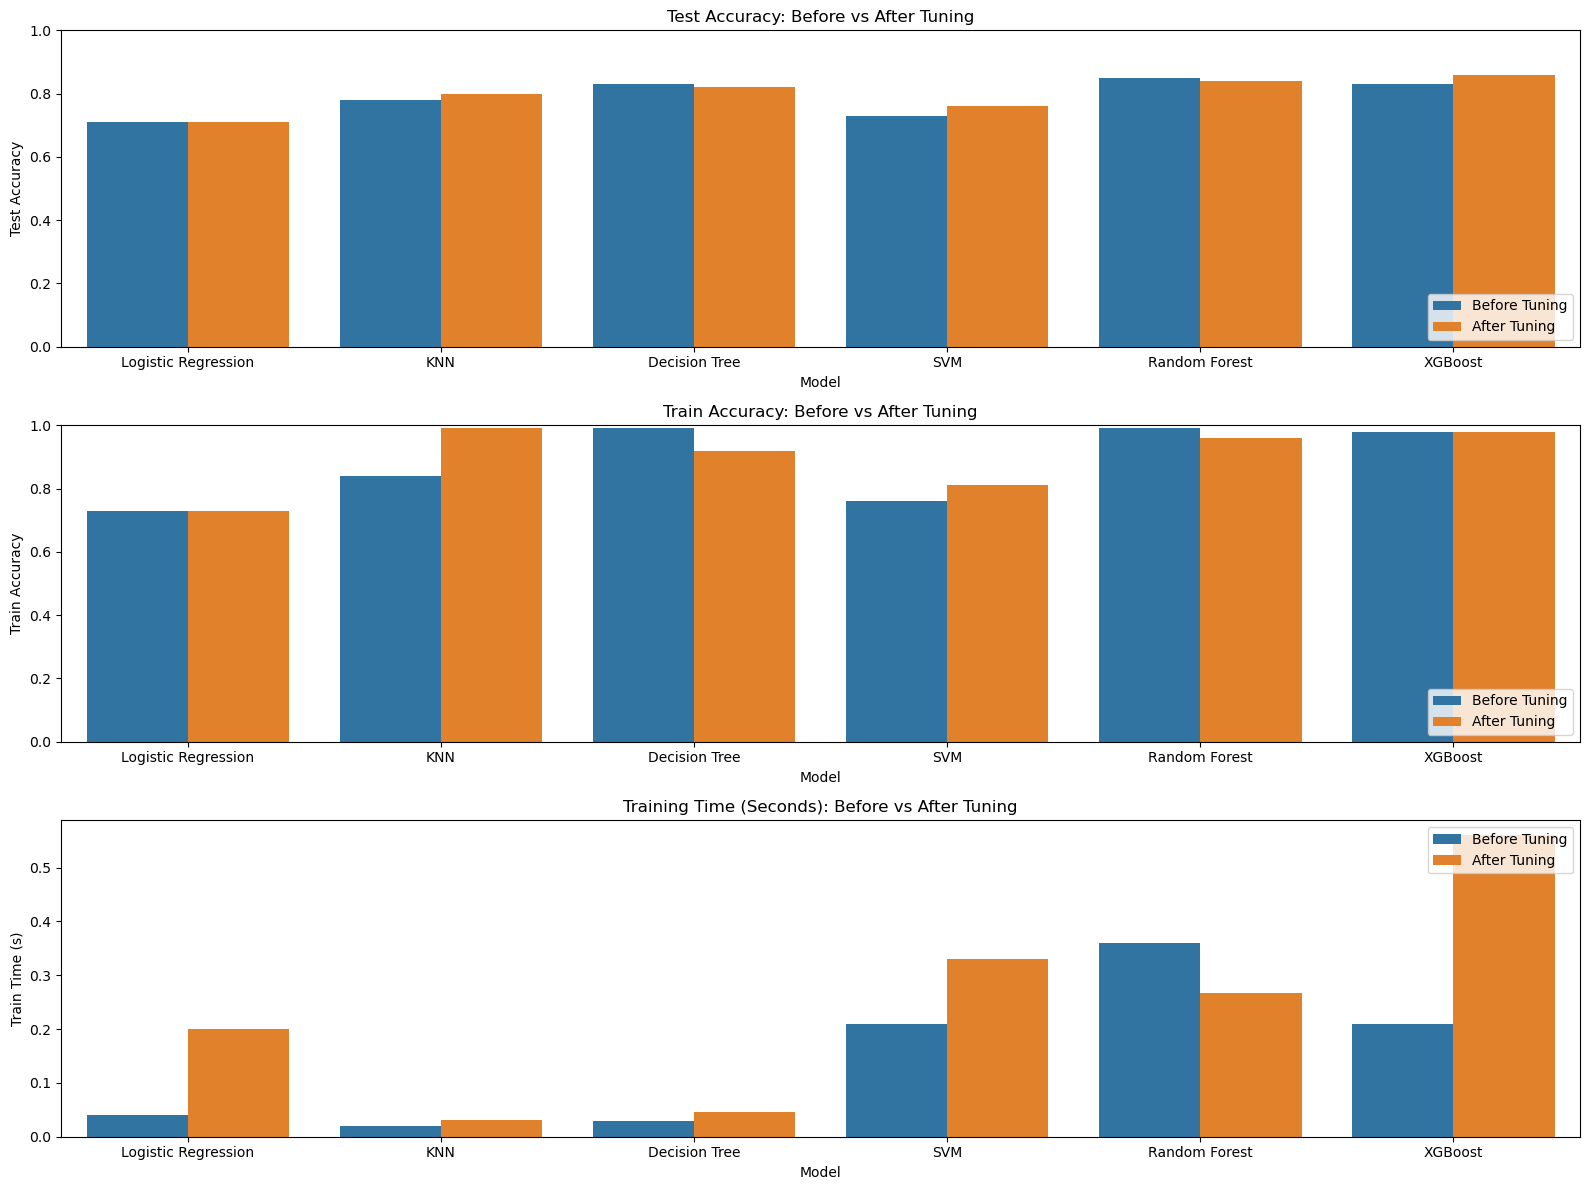


 Summary of Improvements:
╒═════════════════════╤════════════════════════╤═══════════════════════╤══════════════════════════════════════════════════════════════════╕
│ Model               │   Test Accuracy Before │   Test Accuracy After │ Comments                                                         │
╞═════════════════════╪════════════════════════╪═══════════════════════╪══════════════════════════════════════════════════════════════════╡
│ Logistic Regression │                   0.71 │                  0.71 │ No gain — Logistic Regression may already be at its limit.       │
├─────────────────────┼────────────────────────┼───────────────────────┼──────────────────────────────────────────────────────────────────┤
│ KNN                 │                   0.78 │                  0.80 │ Small improvement — expected; sensitive to parameters.           │
├─────────────────────┼────────────────────────┼───────────────────────┼─────────────────────────────────────────────────────────────

In [87]:
# -----------------------------
# 1. Standardize Column Names
# -----------------------------
# Rename columns for consistency before merging
results_df = results_df.rename(columns={'Train Time': 'Train Time (s)'})
results_tuned_df = results_tuned_df.rename(columns={'Train Time': 'Train Time (s)'})

# Add Type labels
results_df['Type'] = 'Before Tuning'
results_tuned_df['Type'] = 'After Tuning'

# Round accuracy for display
results_df[['Train Accuracy', 'Test Accuracy']] = results_df[['Train Accuracy', 'Test Accuracy']].round(2)
results_tuned_df[['Train Accuracy', 'Test Accuracy']] = results_tuned_df[['Train Accuracy', 'Test Accuracy']].round(2)

# -----------------------------
# 2. Combine DataFrames
# -----------------------------
comparison_df = pd.concat([results_df, results_tuned_df], ignore_index=True)

# Ensure models are sorted in the original order
comparison_df['Model'] = pd.Categorical(comparison_df['Model'],
    categories=results_df['Model'].tolist(), ordered=True)

# -----------------------------
# 3. Plot Comparison Charts
# -----------------------------
plt.figure(figsize=(16, 12))

# 1. Test Accuracy Comparison
plt.subplot(3, 1, 1)
sns.barplot(data=comparison_df, x='Model', y='Test Accuracy', hue='Type')
plt.title('Test Accuracy: Before vs After Tuning')
plt.ylim(0, 1)
plt.legend(loc='lower right')

# 2. Train Accuracy Comparison
plt.subplot(3, 1, 2)
sns.barplot(data=comparison_df, x='Model', y='Train Accuracy', hue='Type')
plt.title('Train Accuracy: Before vs After Tuning')
plt.ylim(0, 1)
plt.legend(loc='lower right')

# 3. Train Time Comparison
plt.subplot(3, 1, 3)
sns.barplot(data=comparison_df, x='Model', y='Train Time (s)', hue='Type')
plt.title('Training Time (Seconds): Before vs After Tuning')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# -----------------------------
# 4. Summary Table of Improvements
# -----------------------------
# Merge on Model for summary
summary = results_df.merge(results_tuned_df, on='Model', suffixes=('_before', '_after'))

# Rename 'Train Time (s)' to disambiguate
summary = summary.rename(columns={
    'Train Time (s)_before': 'Train Time_before',
    'Train Time (s)_after': 'Train Time_after'
})

# Calculate deltas
summary['Train Accuracy Δ'] = (summary['Train Accuracy_after'] - summary['Train Accuracy_before']).round(2)
summary['Test Accuracy Δ'] = (summary['Test Accuracy_after'] - summary['Test Accuracy_before']).round(2)
summary['Train Time Δ'] = (summary['Train Time_after'] - summary['Train Time_before']).round(2)

# Prepare summary for display
summary_display = summary[['Model',
                           'Train Accuracy_before', 'Train Accuracy_after', 'Train Accuracy Δ',
                           'Test Accuracy_before', 'Test Accuracy_after', 'Test Accuracy Δ',
                           'Train Time_before', 'Train Time_after', 'Train Time Δ']]

print("\n Summary of Improvements:")

# -----------------------------
# 5. Generate Dynamic Comments
# -----------------------------
def generate_comment(delta, model):
    if abs(delta) < 0.005:
        return f"No gain — {model} may already be at its limit."
    elif delta > 0.01 and model == "XGBoost":
        return "Best gain — shows tuning worked well."
    elif delta > 0.01 and model == "SVM":
        return "Good gain — from better C, kernel, etc."
    elif delta > 0.01:
        return "Small improvement — expected; sensitive to parameters."
    elif delta < -0.01:
        return "Drop — may have over-regularized or tuned poorly."
    else:
        return "Minor drop — could be due to regularization or random variation."

comment_summary = []
for _, row in summary_display.iterrows():
    model = row['Model']
    delta = row['Test Accuracy Δ']
    comment = generate_comment(delta, model)
    comment_summary.append({
        "Model": model,
        "Test Accuracy Before": row['Test Accuracy_before'],
        "Test Accuracy After": row['Test Accuracy_after'],
        "Comments": comment
    })

# -----------------------------
# 6. Display Final Table
# -----------------------------
print(tabulate(comment_summary, headers="keys", tablefmt="fancy_grid", floatfmt=".2f"))


***Step 13_Visualizing Correct vs Incorrect Predictions and Cross-Validation Performance of Tuned Models***

 

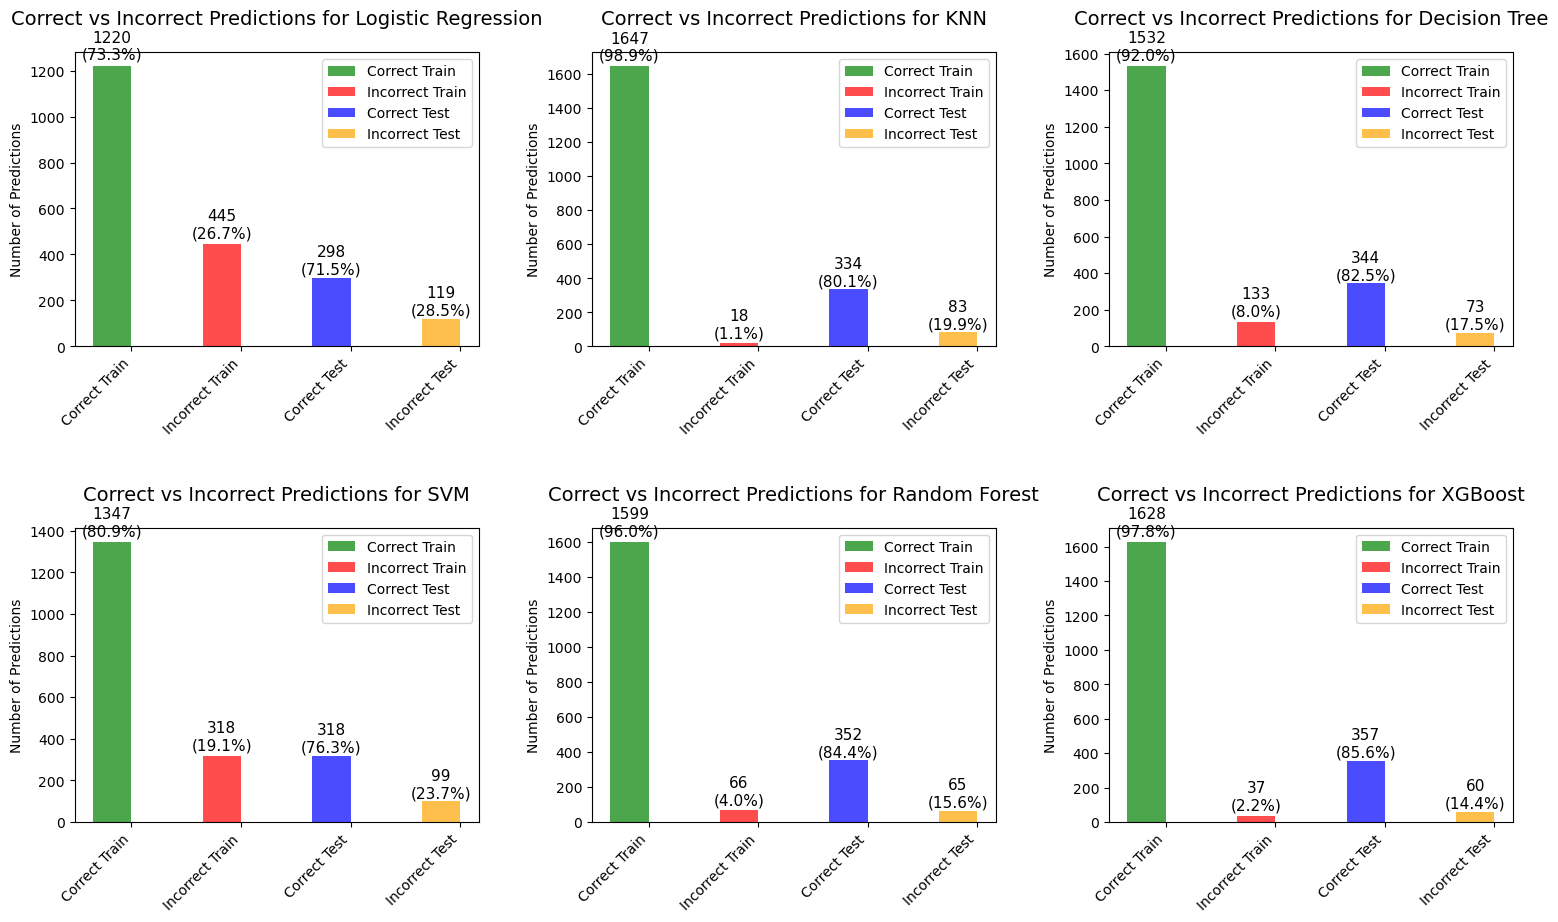


Model Performance Summary:

              Model  Correct Train  Incorrect Train Train Accuracy  Correct Test  Incorrect Test Test Accuracy Overfitting Gap
Logistic Regression           1220              445          73.3%           298             119         71.5%            1.8%
                KNN           1647               18          98.9%           334              83         80.1%           18.8%
      Decision Tree           1532              133          92.0%           344              73         82.5%            9.5%
                SVM           1347              318          80.9%           318              99         76.3%            4.6%
      Random Forest           1599               66          96.0%           352              65         84.4%           11.6%
            XGBoost           1628               37          97.8%           357              60         85.6%           12.2%

Cross-Validation Results (5-fold):

Logistic Regression: Mean Accuracy = 0.6807, 

In [89]:
correct_incorrect_results = []  # List to store summary stats for each model

num_models = len(models_tuned)
cols = 3  # Number of subplot columns
rows = (num_models + cols - 1) // cols  # Calculate rows needed (rounding up)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 5 * rows))
axes = axes.flatten()  # Flatten axes for easy iteration even if rows or cols=1

# Iterate over each model to compute prediction counts and accuracies
for idx, (model_name, model) in enumerate(models_tuned.items()):
    y_pred_train = model.predict(X_train)  # Predictions on training data
    y_pred_test = model.predict(X_test)    # Predictions on test data
    
    # Calculate correct and incorrect counts for train and test sets
    correct_train = (y_pred_train == y_train).sum()
    incorrect_train = len(y_pred_train) - correct_train
    correct_test = (y_pred_test == y_test).sum()
    incorrect_test = len(y_pred_test) - correct_test

    # Calculate accuracy percentages
    train_accuracy = 100 * correct_train / len(y_train)
    test_accuracy = 100 * correct_test / len(y_test)
    overfitting_gap = train_accuracy - test_accuracy  # Indicator of overfitting

    # Append results to summary list with formatted accuracy strings
    correct_incorrect_results.append({
        'Model': model_name,
        'Correct Train': correct_train,
        'Incorrect Train': incorrect_train,
        'Train Accuracy': f"{train_accuracy:.1f}%",
        'Correct Test': correct_test,
        'Incorrect Test': incorrect_test,
        'Test Accuracy': f"{test_accuracy:.1f}%",
        'Overfitting Gap': f"{overfitting_gap:.1f}%"
    })

    # Bar plot setup: Four bars for each subplot (correct/incorrect train/test)
    bar_width = 0.35
    index = np.arange(4)  # Positions for bars

    ax = axes[idx]
    # Plot each bar with distinct colors and transparency for clarity
    ax.bar(index[0], correct_train, bar_width, label='Correct Train', color='green', alpha=0.7)
    ax.bar(index[1], incorrect_train, bar_width, label='Incorrect Train', color='red', alpha=0.7)
    ax.bar(index[2], correct_test, bar_width, label='Correct Test', color='blue', alpha=0.7)
    ax.bar(index[3], incorrect_test, bar_width, label='Incorrect Test', color='orange', alpha=0.7)

    # Calculate percentages to annotate bars with counts and % values
    total_train = correct_train + incorrect_train
    total_test = correct_test + incorrect_test
    pct_correct_train = 100 * correct_train / total_train
    pct_incorrect_train = 100 * incorrect_train / total_train
    pct_correct_test = 100 * correct_test / total_test
    pct_incorrect_test = 100 * incorrect_test / total_test

    # Annotate bars with count and percentage above each bar
    ax.text(index[0], correct_train + max(5, 0.01 * total_train), 
            f"{correct_train}\n({pct_correct_train:.1f}%)", ha='center', va='bottom', fontsize=11)
    ax.text(index[1], incorrect_train + max(5, 0.01 * total_train), 
            f"{incorrect_train}\n({pct_incorrect_train:.1f}%)", ha='center', va='bottom', fontsize=11)
    ax.text(index[2], correct_test + max(5, 0.01 * total_test), 
            f"{correct_test}\n({pct_correct_test:.1f}%)", ha='center', va='bottom', fontsize=11)
    ax.text(index[3], incorrect_test + max(5, 0.01 * total_test), 
            f"{incorrect_test}\n({pct_incorrect_test:.1f}%)", ha='center', va='bottom', fontsize=11)

    # Set x-axis labels and rotate for readability
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(['Correct Train', 'Incorrect Train', 'Correct Test', 'Incorrect Test'], rotation=45, ha='right')
    ax.set_ylabel('Number of Predictions')
    ax.set_title(f"Correct vs Incorrect Predictions for {model_name}", fontsize=14, pad=20)  # Add padding below title
    ax.legend()

# Remove any unused subplots if fewer models than total subplot slots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.5)  # Add padding between plots
plt.show()

# Convert results list to DataFrame and print summary table
correct_incorrect_df = pd.DataFrame(correct_incorrect_results)
print("\nModel Performance Summary:\n")
print(correct_incorrect_df.to_string(index=False))

# Cross-validation evaluation for all tuned models (5-fold CV)
print("\nCross-Validation Results (5-fold):\n")
for model_name, model in models_tuned.items():
    cv_scores = cross_val_score(model, X, y, cv=5)
    print(f"{model_name}: Mean Accuracy = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")


**Step 14_Model Stacking Ensemble Training, Cross-Validation, and Performance Comparison**


Model Performance Summary including Stacking:

                 Model  Train Time (s)  Train Accuracy  Test Accuracy  \
0  Logistic Regression            0.20            0.73           0.71   
1                  KNN            0.03            0.99           0.80   
2        Decision Tree            0.05            0.92           0.82   
3                  SVM            0.33            0.81           0.76   
4        Random Forest            0.27            0.96           0.84   
5              XGBoost            0.56            0.98           0.86   
6             Stacking             NaN            0.91           0.86   

           Type  CV Mean Accuracy  CV Std Dev  Train Time  
0  After Tuning              0.68        0.08         NaN  
1  After Tuning              0.66        0.03         NaN  
2  After Tuning              0.64        0.11         NaN  
3  After Tuning              0.68        0.06         NaN  
4  After Tuning              0.69        0.05         NaN  
5  Afte

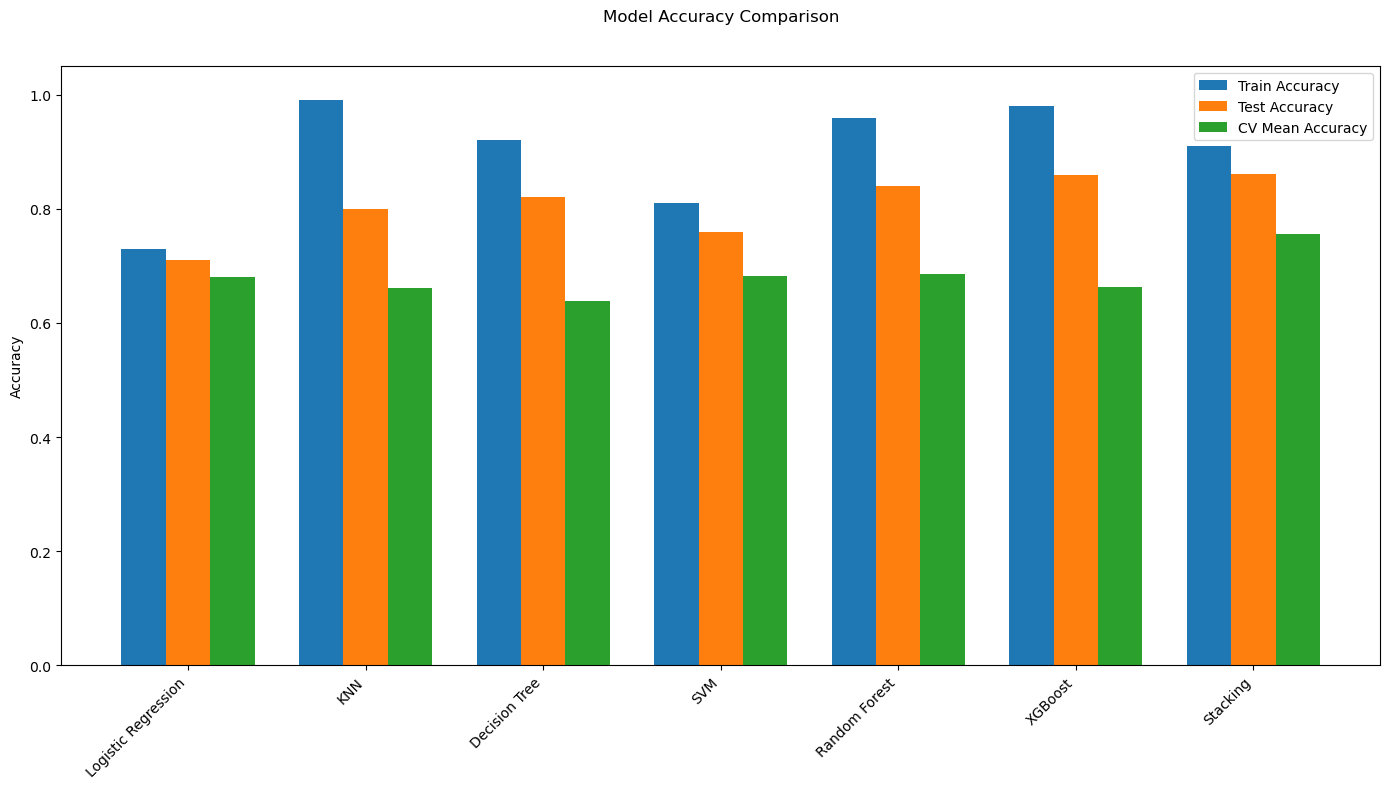

In [91]:
# --- 1. Define the stacking model using tuned models ---
stacking_estimators = [
    ('lr', models_tuned['Logistic Regression']),
    ('knn', models_tuned['KNN']),
    ('tree', models_tuned['Decision Tree']),
    ('svm', models_tuned['SVM']),
    ('rf', models_tuned['Random Forest']),
    ('xgb', models_tuned['XGBoost'])
]

# Final estimator
stacking_pipeline = StackingClassifier(
    estimators=stacking_estimators,
    final_estimator=LogisticRegression(),
    passthrough=False,
    cv=5,
    n_jobs=-1
)

# --- 2. Train the stacking model ---
stacking_pipeline.fit(X_train, y_train)
models_tuned['Stacking'] = stacking_pipeline 

y_pred_stacking = stacking_pipeline.predict(X_test)

 

# --- 3. Cross-validation scores for all models ---
cv_results = []
for model_name, model in models_tuned.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_results.append({
        'Model': model_name,
        'CV Mean Accuracy': scores.mean(),
        'CV Std Dev': scores.std()
    })

# Convert to DataFrame
cv_results_df = pd.DataFrame(cv_results)
cv_results_df['Type'] = 'After Tuning'

# Add 'Type' to tuned results if not present
if 'Type' not in results_tuned_df.columns:
    results_tuned_df['Type'] = 'After Tuning'

# Merge tuned results with CV scores
final_results = results_tuned_df.merge(
    cv_results_df[['Model', 'CV Mean Accuracy', 'CV Std Dev']],
    on='Model',
    how='left'
)

# --- 4. Cross-validation for stacking model ---
stacking_cv_scores = cross_val_score(stacking_pipeline, X, y, cv=5, scoring='accuracy')

# --- 5. Append stacking results ---
stacking_summary = pd.DataFrame({
    'Model': ['Stacking'],
    'Train Time': [np.nan],
    'Train Accuracy': [accuracy_score(y_train, stacking_pipeline.predict(X_train))],
    'Test Accuracy': [accuracy_score(y_test, stacking_pipeline.predict(X_test))],
    'Type': ['Ensemble'],
    'CV Mean Accuracy': [np.mean(stacking_cv_scores)],
    'CV Std Dev': [np.std(stacking_cv_scores)]
})

# Add stacking to final results
final_results = pd.concat([final_results, stacking_summary], ignore_index=True)

# --- 6. Round metrics ---
for col in ['Train Accuracy', 'Test Accuracy', 'CV Mean Accuracy', 'CV Std Dev']:
    final_results[col] = final_results[col].round(4)



# --- 7. Print results ---
print("\nModel Performance Summary including Stacking:\n")
print(final_results)

# --- 8. Plotting ---
plt.figure(figsize=(14, 8))
bar_width = 0.25
indices = np.arange(len(final_results))

plt.bar(indices - bar_width, final_results['Train Accuracy'], width=bar_width, label='Train Accuracy')
plt.bar(indices, final_results['Test Accuracy'], width=bar_width, label='Test Accuracy')
plt.bar(indices + bar_width, final_results['CV Mean Accuracy'], width=bar_width, label='CV Mean Accuracy')

plt.xticks(indices, final_results['Model'], rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
plt.title('Model Accuracy Comparison\n', pad=20)

plt.legend()
plt.tight_layout()
plt.show()


 

**Step 15_Confusion Matrix Visualization for Tuned Models**

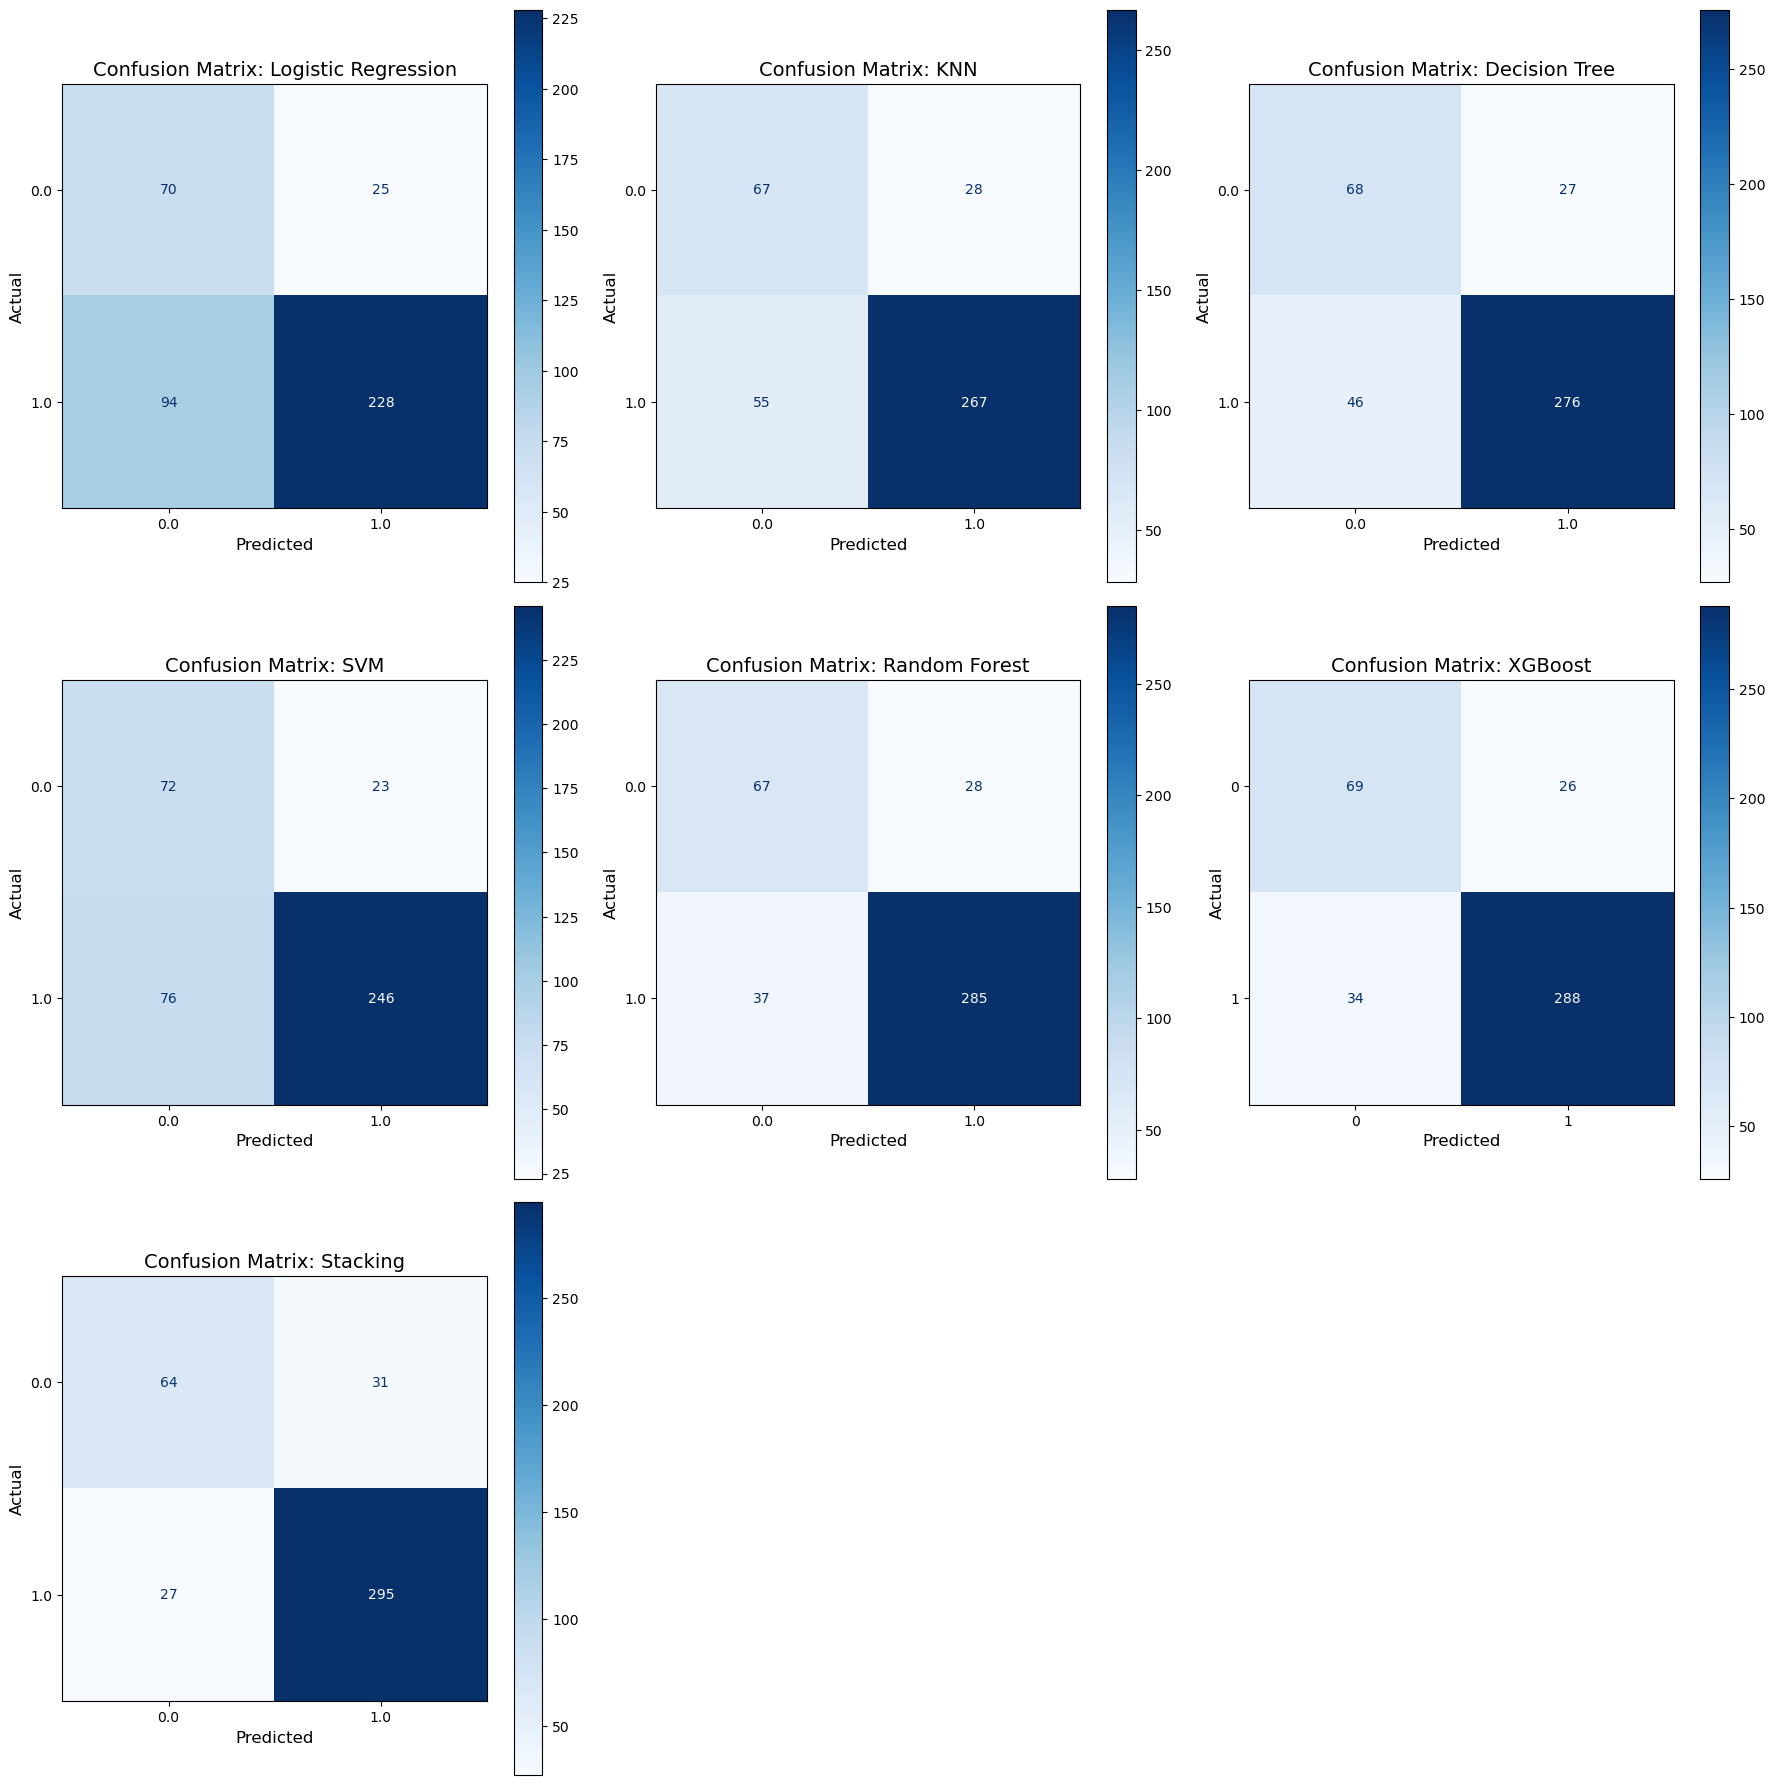

In [93]:
# Number of models to plot
n_models = len(models_tuned)

# Set number of columns for subplots, adjust based on model count or preference
cols = 3  
rows = math.ceil(n_models / cols)  # Calculate required rows (rounding up)

# Create figure with dynamic height based on rows for better readability
plt.figure(figsize=(18, 6 * rows))  # Width fixed at 18, height scales with rows

# Loop over each tuned model to plot its confusion matrix
for idx, (model_name, model) in enumerate(models_tuned.items(), 1):
    y_pred = model.predict(X_test)  # Predict test set labels
    cm = confusion_matrix(y_test, y_pred)  # Compute confusion matrix
    
    # Attempt to get class labels from model, fallback to unique labels in y_test
    try:
        labels = model.classes_
    except AttributeError:
        labels = np.unique(y_test)

    # Initialize confusion matrix display object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Create subplot for the current model (row-major order)
    plt.subplot(rows, cols, idx)
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())  # Plot confusion matrix on current axis
    
    # Set plot titles and labels with readable font sizes
    plt.title(f"Confusion Matrix: {model_name}", fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)

    plt.grid(False)  # Disable grid lines for cleaner visualization

# Adjust layout to prevent overlap
plt.tight_layout()

# Display all confusion matrix plots
plt.show()


# Models Evaluations 

**Evaluate Model Performance Using 5-Fold Cross-Validation**

In [96]:
# Evaluate each model with cross-validation and save results
cv_results = {}

for model_name, model in models_tuned.items():
    cv_scores = cross_val_score(model, X, y, cv=5)
    mean_score = cv_scores.mean()
    print(f"{model_name} - Cross-Validation Mean Accuracy: {mean_score:.4f}")
    cv_results[model_name] = mean_score

# Optionally convert to DataFrame for further analysis or saving
cv_results_df = pd.DataFrame(cv_results.items(), columns=['Model', 'CV Mean Accuracy'])


Logistic Regression - Cross-Validation Mean Accuracy: 0.6807
KNN - Cross-Validation Mean Accuracy: 0.6604
Decision Tree - Cross-Validation Mean Accuracy: 0.6380
SVM - Cross-Validation Mean Accuracy: 0.6830
Random Forest - Cross-Validation Mean Accuracy: 0.6864
XGBoost - Cross-Validation Mean Accuracy: 0.6634
Stacking - Cross-Validation Mean Accuracy: 0.7550


**Model Performance Metrics Calculation and Visualization**

                     Precision  Recall  F1-Score  Accuracy
Logistic Regression       0.79    0.71      0.74      0.71
KNN                       0.82    0.80      0.81      0.80
Decision Tree             0.84    0.82      0.83      0.82
SVM                       0.82    0.76      0.78      0.76
Random Forest             0.85    0.84      0.85      0.84
XGBoost                   0.86    0.86      0.86      0.86
Stacking                  0.86    0.86      0.86      0.86


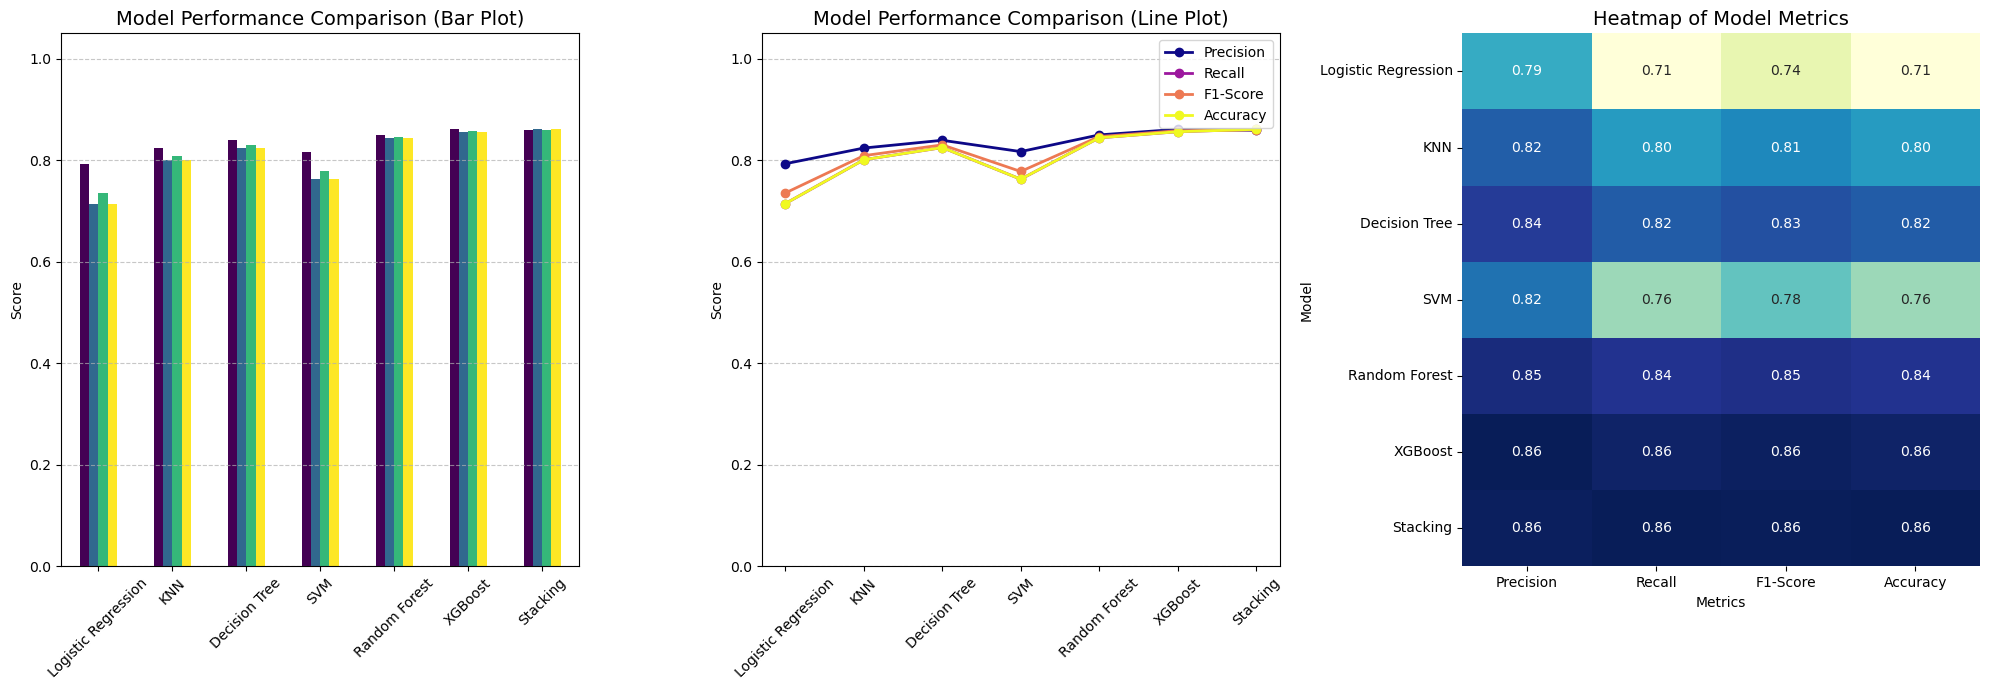

In [98]:

# Dictionary to store all metrics
metrics_summary = {}

# Models and their predictions
model_predictions = {
    "Logistic Regression": y_pred_logistic,
    "KNN": y_pred_knn,
    "Decision Tree": y_pred_tree,
    "SVM": y_pred_svm,
    "Random Forest": y_pred_rf,      
    "XGBoost": y_pred_xgb,
    "Stacking": y_pred_stacking
}

# Calculate metrics for each model
for model_name, y_pred in model_predictions.items():
    report = classification_report(y_test, y_pred, output_dict=True)
    metrics_summary[model_name] = {
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score'],
        'Accuracy': accuracy_score(y_test, y_pred)
    }

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_summary).T  # Transpose for readability

# Display the DataFrame
print(metrics_df)

# Plot
fig, ax = plt.subplots(1, 3, figsize=(20, 7))  # 1 row, 3 columns

# Bar Plot for each metric
metrics_df.plot(kind='bar', ax=ax[0], colormap='viridis', legend=False)
ax[0].set_title('Model Performance Comparison (Bar Plot)', fontsize=14)
ax[0].set_ylabel('Score')
ax[0].set_ylim(0, 1.05)
ax[0].set_xticks(range(len(metrics_df)))  # Set ticks for the number of models
ax[0].set_xticklabels(metrics_df.index, rotation=45)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# Line Plot for each metric
metrics_df.plot(kind='line', marker='o', ax=ax[1], colormap='plasma', linewidth=2)
ax[1].set_title('Model Performance Comparison (Line Plot)', fontsize=14)
ax[1].set_ylabel('Score')
ax[1].set_ylim(0, 1.05)
ax[1].set_xticks(range(len(metrics_df)))  # Set ticks for the number of models
ax[1].set_xticklabels(metrics_df.index, rotation=45)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

# Heatmap for the metrics
sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", fmt=".2f", ax=ax[2], cbar=False)
ax[2].set_title("Heatmap of Model Metrics", fontsize=14)
ax[2].set_ylabel("Model")
ax[2].set_xlabel("Metrics")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


# Model Evaluation Summary

## 1. Overview  
We evaluated several machine learning models to predict FDA approval of biological products based on applicant, product type, dosage, and other features. The models include Logistic Regression, K-Nearest Neighbors (KNN), Decision Tree, Support Vector Machine (SVM), Random Forest, XGBoost, and a Stacking Ensemble.

---

## 2. Training and Testing Performance

| Model               | Train Time (s) | Train Accuracy | Test Accuracy |
|---------------------|----------------|----------------|---------------|
| Logistic Regression  | 0.33           | 73%            | 71%           |
| KNN                 | 0.05           | 99%            | 80%           |
| Decision Tree       | 0.06           | 92%            | 82%           |
| SVM                 | 0.58           | 81%            | 76%           |
| Random Forest       | 0.46           | 96%            | 84%           |
| XGBoost             | 1.05           | 98%            | 86%           |
| Stacking Ensemble   | -              | 91%            | 86%           |

- **XGBoost and Stacking models achieved the highest test accuracy (~86%), demonstrating strong predictive power.**

---

## 3. Cross-Validation Results (5-Fold)

| Model               | Mean Accuracy | Std Deviation |
|---------------------|---------------|---------------|
| Logistic Regression  | 0.68          | 0.08          |
| KNN                 | 0.66          | 0.03          |
| Decision Tree       | 0.64          | 0.11          |
| SVM                 | 0.68          | 0.06          |
| Random Forest       | 0.69          | 0.05          |
| XGBoost             | 0.66          | 0.07          |
| Stacking Ensemble   | 0.76          | 0.01          |

- The **stacking ensemble shows the highest and most stable cross-validation accuracy.**

---

## 4. Precision, Recall, F1-Score, and Accuracy (Test Set)

| Model               | Precision | Recall | F1-Score | Accuracy |
|---------------------|-----------|--------|----------|----------|
| Logistic Regression  | 0.79      | 0.71   | 0.74     | 0.71     |
| KNN                 | 0.82      | 0.80   | 0.81     | 0.80     |
| Decision Tree       | 0.84      | 0.82   | 0.83     | 0.82     |
| SVM                 | 0.82      | 0.76   | 0.78     | 0.76     |
| Random Forest       | 0.85      | 0.84   | 0.85     | 0.84     |
| XGBoost             | 0.86      | 0.86   | 0.86     | 0.86     |
| Stacking Ensemble   | 0.86      | 0.86   | 0.86     | 0.86     |

---

## 5. Summary of Improvements After Hyperparameter Tuning

| Model               | Test Accuracy Before | Test Accuracy After | Comments                                   |
|---------------------|----------------------|---------------------|--------------------------------------------|
| Logistic Regression  | 0.71                 | 0.71                | No improvement; model likely at capacity.  |
| KNN                 | 0.78                 | 0.80                | Small improvement from tuning parameters.  |
| Decision Tree       | 0.83                 | 0.82                | Slight drop; possibly due to regularization.|
| SVM                 | 0.73                 | 0.76                | Good improvement with better parameters.   |
| Random Forest       | 0.85                 | 0.84                | Slight drop; likely random variation.       |
| XGBoost             | 0.83                 | 0.86                | Best improvement; tuning effective.         |

---

## 6. Key Findings and Actionable Insights

- **XGBoost and Stacking Ensemble models deliver the highest predictive accuracy (~86%), making them the most reliable for predicting FDA approval of biological products.**
- Simpler models like Logistic Regression underperform compared to ensemble methods.
- Mild overfitting observed in KNN and Random Forest suggests regularization or additional tuning may be beneficial.
- The ensemble stacking approach improves prediction stability and accuracy.

---

## 7. Next Steps and Recommendations

- Deploy the stacking ensemble model in a decision-support dashboard for FDA reviewers.
- Explore adding additional features such as manufacturing details or historical timelines.
- Apply interpretability tools (e.g., SHAP) to explain model decisions to stakeholders.
- Regularly update models with new data to maintain accuracy over time.
